# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects using Open Images dataset.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Select GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

W0815 14:53:20.093277 140146932143936 deprecation_wrapper.py:119] From /shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 14:53:20.120707 140146932143936 deprecation_wrapper.py:119] From /shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 14:53:20.124765 140146932143936 deprecation_wrapper.py:119] From /shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 14:53:20.150069 140146932143936 deprecation_wrapper.py:119] From /shenlab/lab_stor/zhenghan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_bat

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [5]:
# Open Images Class names
class_names_open_df = pd.read_csv("../open-images/challenge-2019-instance-segmentation-track-annotations/challenge-2019-classes-description-segmentable.csv")
class_names_open_dict = class_names_open_df.to_dict('record')
class_names_open = {x['Label']: x['Name'] for x in class_names_open_dict}
class_labels_open = {x['Name']: x['Label'] for x in class_names_open_dict}

#for i in range(81):
#    if class_names[i].capitalize() in class_labels_open:
#        print(i, class_names[i].capitalize(), class_labels_open[class_names[i].capitalize()])


## Run Object Detection

In [6]:
# Read csv files
truncated_df = pd.read_csv("../open-images/sample_truncated_submission.csv")
empty_df = pd.read_csv("../open-images/sample_empty_submission.csv")
truncated_df['PredictionString'][3]
truncated_dict = truncated_df.to_dict('record')
truncated_image_IDs = truncated_df.to_dict('list')['ImageID']
pred_str_list = truncated_dict[0]['PredictionString'].split(' ')
result = {'class_ids': [], 'scores': [], 'masks': []}
for i in range(0, len(pred_str_list), 3):
    result['class_ids'].append(class_names_open[pred_str_list[i]])
    result['scores'].append(pred_str_list[i+1])
    #result['masks'].append(decode_binary_mask(bytes(pred_str_list[i+2], encoding='utf-8'), (image.shape[0], image.shape[1])))
truncated_df


,ImageID,ImageWidth,ImageHeight,PredictionString
0,d390310a4ce1c08a,1080,1080,/m/01pns0 0.754811 eNqdlWmTmzgQhv+SDvCMPRWOmth...
1,851ead69b88d02ec,905,1599,/m/01g317 0.57979 eNplj0sOwyAMRK/kMfQUNUZ02U9E...
2,6bfa7127523df860,768,768,/m/0k4j 0.97572 eNoLzMsxCDDMSzMw9jP0B0EDQwM4aW...
3,1bdcf167aa8486c3,1600,1200,/m/01g317 0.87176 eNp9VMlygzAM/SUZZxmaXjrNuEuK...
4,56cffbbb9ef25c1f,-1,-1,NaN
5,3c98050656fcae7f,1066,1600,/m/01g317 0.996779 eNo1UmFvozAM/UsOEE5sU+82Xdu...
6,721568e01a744247,1118,1600,/m/018xm 0.637833 eNqLi8xJM7BOTjS08DT2NfI38Dfy...
7,7b018c5e3a20daba,1600,1066,/m/01g317 0.85117 eNqLiYrLN7DNCjDMMIj0N/Iz9Dcw...
8,414f07ba363e7e01,1600,1066,/m/01g317 0.97475 eNplU2mTmzAM/UsyEEhnOj1mdpol...
9,d446e853f7ad30d3,1600,900,/m/01g317 0.971963 eNpNj31zgjAMxr9SSlFxu9vtznO...


Processing 1 images
image                    shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


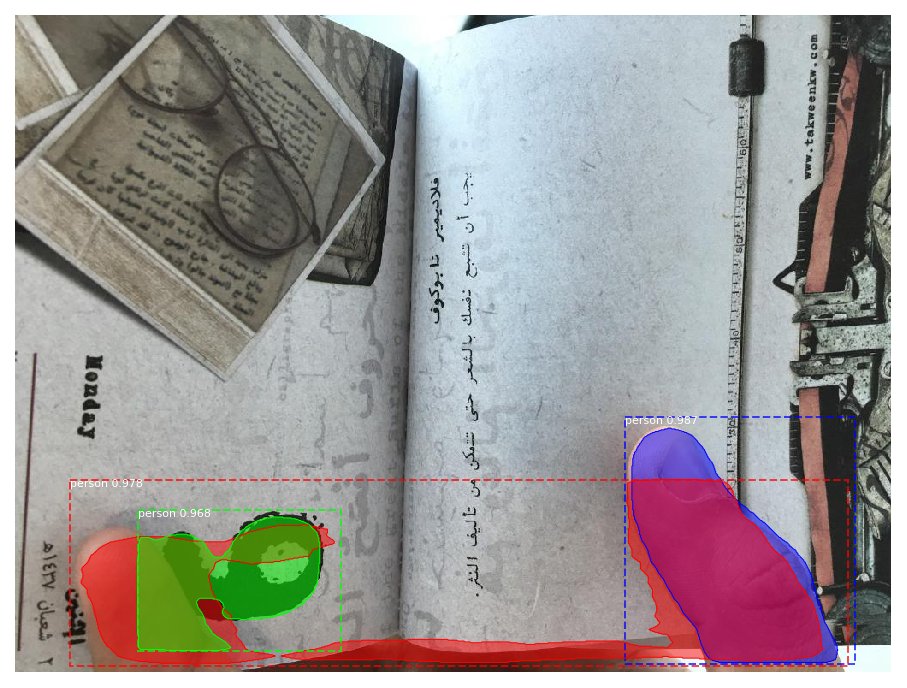

In [7]:
# Load a test image
IMAGE_DIR = "../open-images/test_challenge_2018"
file_name = '1bdcf167aa8486c3.jpg'
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
image_id = os.path.splitext(file_name)[0]

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

## Encode Segmentation Mask

In [15]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)
    
    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

def decode_binary_mask(base64_str: t.Text, img_size: tuple) -> np.ndarray:
    """Converts OID challenge encoding ascii text into a binary mask."""
    
    # base64 decoding and decompress --
    binary_str = base64.b64decode(base64_str)
    encoded_mask = zlib.decompress(binary_str)
    
    # RLE decode mask --
    mask_to_encode = coco_mask.decode([{'size': list(img_size), 'counts': encoded_mask}])
    
    # convert COCO API output to expected mask --
    mask_to_encode = np.ascontiguousarray(mask_to_encode)
    mask_to_encode = mask_to_encode.astype(np.bool)
    mask = np.squeeze(mask_to_encode)
    
    return mask

# Check correctness of decode_binary_mask
mask = results[0]['masks'][:,:,0]
de_mask = decode_binary_mask(encode_binary_mask(mask), (image.shape[0], image.shape[1]))
sum(sum(abs(mask.astype(np.uint8) - de_mask.astype(np.uint8))))

0

In [17]:
#print(results[0])
def generate_PredictionString(result, verbose=0):
    out = ""
    for i in range(len(result['class_ids'])):
        if len(out) > 0:
            out += ' '
        class_name = class_names[result['class_ids'][i]].capitalize()
        if class_name in class_labels_open:
            out += class_labels_open[class_name] + ' ' + str(result['scores'][i]) + ' ' + str(encode_binary_mask(result['masks'][:,:,i]), encoding='utf-8')
        elif verbose == 1:
            print('Class [' + class_name + '] not included in Open Images Challenge (Instance Segmentation Track)')
    return out

generate_PredictionString(results[0])


'/m/01g317 0.99986625 eNqNlVmXsjgQhv8SBAp6pOecOae1GwrCKojIIoqACPL/76bEvb+5GGPy1FtZIEkljG0r+2JeCZk42gchdT4X2mKmKwiWbElc4lRa8kTZBEpUg6quooKKoVx9nNnSMzuiLTrMZlN5y+R9ZNKPGkEg+1bek00j5ObupzCLj0T29I3pf2Rypq/Ng1rJpR6bW7WWD3poZmonN7pvJmovd7pnrtSz3Osjhuooj/oZfdUDz+jRVQMIjA7PSghLYk9cGS2elAhio8GjsoLUqLBWNpAbJVZKCqWxxa2SQ22kmCkldEaMsVJDAFy+zfU5Y/ac8X0Gl+wIztUShBc9KVEQb5rUpf9Uf5//xXf3PPpc1lW4UHiWk+eu6DeNd/2JgnP1X4yLdf1f5at+bfPodcs3/7Pm1f/nUA/96Ca+bK1w997998f8eqjwDIbrIl/SxPIrN2MKgkJvaPNTOdZdq1KXFCSR1auDNPwklvvRSt1PYQUfldT87KzoYytl3yuzsXOxm2WS992aJ3sUAm0jnRa+1dq1kGmJtF9s7XR2FKNFanezQvnjne4L/bYBzuvy/x/1Pr9HwL+k91a/W9+0zX61vL3bPXica7jcVvFyKC9BFtnZV4DV5wGarwjTzx30XymGnwX48xxHbQvhPMNeK2E1T7HT9rCeb7DWDpDOE6y0CgrSW9L7+RozrYZ6vsJEO8JxHmKkdXCeL9HXTuAtAjzPeogWPnazAdYLF5vZCNliNHYzVymJBekDMSF9JEYzT+kXgxHOfGUg+kT/uzeGv5aKJznCI+Kct1gUHidkqrndKNezcLPE+/GYOj4cky28n6CHw362ew5wsZaLxvCUWHHxZPQQKkscjRY8ZY0eVkBTRB9LOMMWl5jDCfYTO6gwxGwiLT0c4TCxhRpjTKCGFhOMoYION7iCPZwwwxBKGLDAAHJwzRI9yMAz9zjKdHOZHbZyJ4XfnnUAiORQWvOT1bBA2v

In [18]:
def generate_csv_row(image, image_id, result, verbose=0):
    return pd.DataFrame({'ImageID': [image_id], 'ImageWidth': [image.shape[0]], 'ImageHeight': [image.shape[1]], 
                         'PredictionString': [generate_PredictionString(result, verbose=0)]})
generate_csv_row(image, image_id, results[0])

,ImageID,ImageWidth,ImageHeight,PredictionString
0,0002f94fe2d2eb9f,682,1024,/m/01g317 0.99986625 eNqNlVmXsjgQhv8SBAp6pOecO...


In [19]:
# Get test results (pandas.DataFrame)
submission_list = []
file_names = next(os.walk(IMAGE_DIR))[2]
for i in range(len(file_names)):
    file_name = file_names[i]
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
    image_id = os.path.splitext(file_name)[0]
    print('Processing ' + file_name)
    
    # Run detection
    results = model.detect([image], verbose=0)
    
    # Visualize results
    r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
    #                        class_names, r['scores'])
    
    submission_list.append(generate_csv_row(image, image_id, r))

submission_df = pd.concat(submission_list, ignore_index=True)
submission_df

Processing 0001244aa8ed3099.jpg
Processing 0003a523fa9b2a3f.jpg
Processing 00000b4dcff7f799.jpg
Processing 0000d67245642c5f.jpg
Processing 0001dd930912683d.jpg
Processing 00001a21632de752.jpg
Processing 0002c96937fae3b3.jpg
Processing 0001c8fbfb30d3a6.jpg
Processing 000172d1dd1adce0.jpg
Processing 000305ba209270dc.jpg
Processing 0008501b0c5108ab.jpg
Processing 0003d1c3be9ed3d6.jpg
Processing 0004fdbc5b94c7c2.jpg
Processing 0005facd8dbaf39a.jpg
Processing 0002f94fe2d2eb9f.jpg
Processing 000313fed9979d24.jpg
Processing 000455be7b222c04.jpg
Processing 0005339c44e6071b.jpg
Processing 0005fcc2fd4eaa4a.jpg
Processing 0005aea8c9144c77.jpg
Processing 0008348dfbd5d85f.jpg
Processing 0007ffd0ba02c9ce.jpg
Processing 000a017e2b7063a7.jpg
Processing 0007c05c94bcf41b.jpg
Processing 000d6aba3b0af069.jpg
Processing 000912f449df9180.jpg
Processing 0008525fb2879723.jpg
Processing 0007e8279612ac07.jpg
Processing 000b39037205b35d.jpg
Processing 00069966ba8519e5.jpg
Processing 00117c463ac41e45.jpg
Processi

Processing 00858708a7175c1e.jpg
Processing 00943dc18453cd26.jpg
Processing 0090e93cf70cf6d7.jpg
Processing 008f81d20d9e2b4e.jpg
Processing 0093568c2f73c04e.jpg
Processing 0095db1e44b6872c.jpg
Processing 00957e4f52f4534d.jpg
Processing 00931322c904fbd3.jpg
Processing 008d89f7ab35e4a3.jpg
Processing 009167c96694a4a7.jpg
Processing 0094a9462f5fb0db.jpg
Processing 009e0105d9abb3b3.jpg
Processing 009816310d1961e8.jpg
Processing 0095ab693be8121e.jpg
Processing 009636b3c5aa77e6.jpg
Processing 00939ae6af6091c9.jpg
Processing 0097cac52cd91a9d.jpg
Processing 008f02101eba33d8.jpg
Processing 0098c12fa50ad68c.jpg
Processing 00963081841d0f89.jpg
Processing 00965cb64a5cf6bc.jpg
Processing 009e302cd340d5d2.jpg
Processing 0098f210c95d1e55.jpg
Processing 009b447e16ab94ce.jpg
Processing 00a0c5ea5b4f3989.jpg
Processing 00a39e755c1c8201.jpg
Processing 009f6931fc3c83a9.jpg
Processing 009d568aa5218bd0.jpg
Processing 00a0fdcd1201c796.jpg
Processing 00a6158794eb6223.jpg
Processing 009ec46d3fd852d8.jpg
Processi

Processing 012a232021f46dff.jpg
Processing 01312becd5a0b2d0.jpg
Processing 012c8c2c64f42140.jpg
Processing 012cca1f9330d7ec.jpg
Processing 01300a28567a9059.jpg
Processing 012d91ac10e7adcd.jpg
Processing 012ee44e82282bb3.jpg
Processing 012f5dc20dc84ca2.jpg
Processing 0135a3dfbc3d7fa7.jpg
Processing 013304017681da6b.jpg
Processing 013066300ac5816b.jpg
Processing 012f426c25767bd8.jpg
Processing 012f436291ea9d36.jpg
Processing 0131b45655759af5.jpg
Processing 012e6fbb96616906.jpg
Processing 013505e65f397784.jpg
Processing 014b7a5b9b467c57.jpg
Processing 013230475d941a44.jpg
Processing 0131d32f90937f3c.jpg
Processing 0138363afba37ddd.jpg
Processing 013afda30cb6b5ad.jpg
Processing 01317a14ff6223d4.jpg
Processing 013a8ca16ca96448.jpg
Processing 013b23ca9b714927.jpg
Processing 013f5df3740aae1a.jpg
Processing 01381e18611e4cb2.jpg
Processing 0139967dc9ece2ef.jpg
Processing 0138b6050550d097.jpg
Processing 0133eabaa204feef.jpg
Processing 013b08c018d09387.jpg
Processing 013d2eee7368068c.jpg
Processi

Processing 01bf9bc39d352e37.jpg
Processing 01b827d59128fc72.jpg
Processing 01bc0c0c8e03e3ad.jpg
Processing 01bbb5311a4fc7d8.jpg
Processing 01c6eeee8d4e8469.jpg
Processing 01bd0285befe6741.jpg
Processing 01bab0de7705fbab.jpg
Processing 01be54e3ad2c98cf.jpg
Processing 01c126595525c8c4.jpg
Processing 01cc9e5e2c3c47ab.jpg
Processing 01c66cf2d592f745.jpg
Processing 01c15e4d6ff7eae4.jpg
Processing 01c040a5c1dc6e22.jpg
Processing 01c4b09b4261f8d0.jpg
Processing 01c3d5fb73188c99.jpg
Processing 01c745e328254ad8.jpg
Processing 01c92dcac27447d7.jpg
Processing 01c762148732abf8.jpg
Processing 01c8352910bf35e4.jpg
Processing 01c2030fc98c4775.jpg
Processing 01cc9afb4bba2270.jpg
Processing 01d02eab552ac8fb.jpg
Processing 01cbe204860241c5.jpg
Processing 01e910f9f8122c00.jpg
Processing 01cb1842b5a6c0e1.jpg
Processing 01cce65b9ea7bbd6.jpg
Processing 01cdddaaf8265b49.jpg
Processing 01d321fc036738d2.jpg
Processing 01d64a01d9096ea5.jpg
Processing 01cb61443a915076.jpg
Processing 01c85f8c9ae67a6b.jpg
Processi

Processing 026030184528dc3e.jpg
Processing 02664f3839d67505.jpg
Processing 02658a0461f36a96.jpg
Processing 02644d7d5c962a54.jpg
Processing 0263793ac76cc088.jpg
Processing 026338e8c5c54b8d.jpg
Processing 0266d2a97f09c0ef.jpg
Processing 0261b381cc29bc38.jpg
Processing 025c4e09f8c0ff11.jpg
Processing 026479f9eadb5506.jpg
Processing 025f60683335a5bf.jpg
Processing 026ba1c9e1c9f899.jpg
Processing 0267452e0e4be6b2.jpg
Processing 026778006fafbe41.jpg
Processing 026bb265c02b9b64.jpg
Processing 0268ebf8b0a0dfaa.jpg
Processing 026bb2f08fe415e4.jpg
Processing 0265a6bcfa9ae3e2.jpg
Processing 0268aae79fb9b937.jpg
Processing 02673066bd06786e.jpg
Processing 0264ea8eb1c6d816.jpg
Processing 026d3db335f85d18.jpg
Processing 026d4733c607831a.jpg
Processing 026c98bbdf3e6842.jpg
Processing 026f6ea88632352c.jpg
Processing 026d1e569df00636.jpg
Processing 027261560f40abfe.jpg
Processing 026e4c03c5d26f03.jpg
Processing 026f9ed89b2ac2e4.jpg
Processing 0275f8686181da3c.jpg
Processing 0271306c423f7522.jpg
Processi

Processing 02eca4b19f2de3ca.jpg
Processing 02f161efc1a605c7.jpg
Processing 02f5c31d0a6e1b32.jpg
Processing 02f1b7a1cfe9d5d5.jpg
Processing 02ef30d7e1897030.jpg
Processing 02f4c0a3f2d60306.jpg
Processing 02f33792d4f7c89e.jpg
Processing 02f35a20cee075c8.jpg
Processing 02f31ac1cff8e3b7.jpg
Processing 02f06bff0da6120b.jpg
Processing 02f11bf8fbe9feb1.jpg
Processing 02fb6f5d040d925f.jpg
Processing 02f4b5fbd07586dd.jpg
Processing 02f6a3199202bdc7.jpg
Processing 02fcc3e300c61397.jpg
Processing 02f8545004eaa67f.jpg
Processing 02f49279b0cb8d4e.jpg
Processing 02fcaff0a060de62.jpg
Processing 02fe874a71222591.jpg
Processing 02fb5513b97d8f1b.jpg
Processing 02ffe2d3ff32595c.jpg
Processing 02fe072456544b3e.jpg
Processing 03008bd20428fc6f.jpg
Processing 02fddc8b04676486.jpg
Processing 02fe926db3c08b61.jpg
Processing 02ffd1335a41f3dd.jpg
Processing 02fd26a641099952.jpg
Processing 03033197fb02bcf0.jpg
Processing 02feb8698f05b24e.jpg
Processing 0300ff3344676a18.jpg
Processing 0300cf1976b7bc1e.jpg
Processi

Processing 038b14b3736520ec.jpg
Processing 038b16304a3d4c65.jpg
Processing 038cc785020991cd.jpg
Processing 0389aaa8f4369fd8.jpg
Processing 038edd196c428606.jpg
Processing 038e1ef92465e08d.jpg
Processing 038b45e67a22800a.jpg
Processing 038ca0055f7096a3.jpg
Processing 039840b3ddd83912.jpg
Processing 038ca846c4a52db7.jpg
Processing 038bb3abce8517f7.jpg
Processing 038739eb500776a0.jpg
Processing 03986d1d28858e44.jpg
Processing 0390a6f1d9044726.jpg
Processing 0390bd512355dcbb.jpg
Processing 03966672c1e9d5b0.jpg
Processing 0390cf678f42a7a2.jpg
Processing 0394f3fb37873ff4.jpg
Processing 03986b8aa791bb35.jpg
Processing 039d05f6082cf7c1.jpg
Processing 0396cd50cb2d6e8d.jpg
Processing 038cca1d77cbdf69.jpg
Processing 039b5a665fa0570b.jpg
Processing 038cfb0e25697f2b.jpg
Processing 03a7adcdd7f00a27.jpg
Processing 039134458c7035d0.jpg
Processing 039cffe045dda7b9.jpg
Processing 039cb8883e8c8610.jpg
Processing 03a09a7374c1f6e2.jpg
Processing 039b1d849d439b1d.jpg
Processing 039dfc36f8af65c7.jpg
Processi

Processing 042f68017ac4bda0.jpg
Processing 042d612ed5ad9bc1.jpg
Processing 04317de72c2fa4d3.jpg
Processing 042d1447e75010c5.jpg
Processing 042e1b83cced9c78.jpg
Processing 0433e902a911da94.jpg
Processing 0433a4004890cc69.jpg
Processing 0433599741c9cd16.jpg
Processing 0432fbd5bc71ff37.jpg
Processing 0437809993ec49b2.jpg
Processing 04339ad9b04d8d6a.jpg
Processing 0436ea2854f72ae1.jpg
Processing 043a9184aa92a9da.jpg
Processing 04341188fb540fb3.jpg
Processing 043a9d1db552ecb6.jpg
Processing 04315241cf2fc351.jpg
Processing 043997f451aa01d9.jpg
Processing 043a8d5cc8b735de.jpg
Processing 0434343b9d3607b8.jpg
Processing 043dad1f1f143b11.jpg
Processing 0437c66cdafc6ac2.jpg
Processing 043a2527277ca0f0.jpg
Processing 043e386e480b5d71.jpg
Processing 0437c1c61ebba55c.jpg
Processing 043f75b84dfc43ac.jpg
Processing 043e1bdb884b9508.jpg
Processing 04430b1384c407de.jpg
Processing 044048463566ed34.jpg
Processing 04405da952ea4f9b.jpg
Processing 043fae148eb3842d.jpg
Processing 0440c68c76bc00f6.jpg
Processi

Processing 04b7ba0a68da0e68.jpg
Processing 04b8c5efe7f03eea.jpg
Processing 04b86a22b373b0ea.jpg
Processing 04bc7c923410fd66.jpg
Processing 04be6091988974cc.jpg
Processing 04bc6af7c9ed9d29.jpg
Processing 04beb574616d3c57.jpg
Processing 04bd9e89afa58e47.jpg
Processing 04c1e70fccb44a90.jpg
Processing 04bdbe0dd8d01789.jpg
Processing 04f69c0b6e497185.jpg
Processing 04c3aa8ff4cc8742.jpg
Processing 04beebfc0aa8936e.jpg
Processing 04bf1dc0ac754352.jpg
Processing 04bf93854bab82c2.jpg
Processing 04c17117d1bb8532.jpg
Processing 04bf2b5b25755ec8.jpg
Processing 04bf98a0b16c5295.jpg
Processing 04c0cf5245b2a9c8.jpg
Processing 04c4d0a6408a52fe.jpg
Processing 04c5d87056937d68.jpg
Processing 04c609baaccf0b3c.jpg
Processing 04c1f4d1b77c00c3.jpg
Processing 04c5285b27523b66.jpg
Processing 04c5fc2ecce03bf6.jpg
Processing 04cdd0a2fdd5fb0a.jpg
Processing 04bbf08dd346c0f6.jpg
Processing 04c6b59fb30b7401.jpg
Processing 04c560ec69bb326d.jpg
Processing 04c88b9d8bd69291.jpg
Processing 04c806bb410f6cbc.jpg
Processi

Processing 055ef6f08df845a2.jpg
Processing 056313dc94d9457b.jpg
Processing 055e4f61974df3a6.jpg
Processing 055fe4c8fa95a887.jpg
Processing 0561ca4b3842af57.jpg
Processing 0561b7033b232910.jpg
Processing 055df6a955f86203.jpg
Processing 05628c985a408680.jpg
Processing 0565b66b911a1c47.jpg
Processing 0560343b89b24d60.jpg
Processing 0563ea3c32c122b7.jpg
Processing 0566745254159eed.jpg
Processing 056d9153ed31d426.jpg
Processing 0565d074accd6b07.jpg
Processing 05670c3768dbd362.jpg
Processing 0569c70111341050.jpg
Processing 0566c9a0a6310de9.jpg
Processing 056b3ca3b02ed98c.jpg
Processing 05af3dc27f21c8d5.jpg
Processing 058e2179b372b1fc.jpg
Processing 0576d4ff84f67493.jpg
Processing 056b8c533439559b.jpg
Processing 057031918ecb24ac.jpg
Processing 056f72a2568c5b1b.jpg
Processing 0568033f04eb9469.jpg
Processing 0568a1c2d26f030f.jpg
Processing 056dce9c6a5d7624.jpg
Processing 05682b9851c8471f.jpg
Processing 056a1057ff67c80d.jpg
Processing 056e0704ae61f83a.jpg
Processing 056df1b0c4faec21.jpg
Processi

Processing 06099c975279e155.jpg
Processing 060a4a9a319c8285.jpg
Processing 060931f994c4ab37.jpg
Processing 060a524618b2ac3f.jpg
Processing 061a6d0c7f5e5a69.jpg
Processing 060d41ead20c6282.jpg
Processing 060ac96b60d211f2.jpg
Processing 060ab37e2ce234f6.jpg
Processing 060b5a9d418006b3.jpg
Processing 060d5fab9efd3452.jpg
Processing 0613e629e65e9e22.jpg
Processing 0613b88c696b228d.jpg
Processing 06139476542f0fa6.jpg
Processing 06146f2d98efaa26.jpg
Processing 060e46dcb521f766.jpg
Processing 060f4cf37a1036e3.jpg
Processing 061463d33cf25172.jpg
Processing 06167a06256ef0c3.jpg
Processing 06154a8a3915bcb0.jpg
Processing 06157ea44ab3e07f.jpg
Processing 061658bc997ec24d.jpg
Processing 06159c32cfae1abd.jpg
Processing 0616ed7cd288c11f.jpg
Processing 061b67324e2e8f0a.jpg
Processing 061722e7efea1753.jpg
Processing 061b718ae80dcd28.jpg
Processing 0635c1a2b5eeda28.jpg
Processing 06380401c9f3f260.jpg
Processing 061d52651fd05851.jpg
Processing 061d4d1486322b2f.jpg
Processing 061db714c0229fda.jpg
Processi

Processing 069b5fd5063c4338.jpg
Processing 06928526908ab5a9.jpg
Processing 069c38b560e7ba10.jpg
Processing 069ca8b5f741daa8.jpg
Processing 069eeb443c3f3a19.jpg
Processing 06a022df2a7e9b10.jpg
Processing 069f798c5657111d.jpg
Processing 069facf9127c348a.jpg
Processing 06a211c28c063d4c.jpg
Processing 06a29428ee72d414.jpg
Processing 06a2c1550eded19d.jpg
Processing 06a2018500bd233c.jpg
Processing 06a0ed6bb1857a18.jpg
Processing 069fddc65c4bc8f6.jpg
Processing 06a2bb95f82e05cc.jpg
Processing 06a469d3f07983ad.jpg
Processing 06a2446043464f02.jpg
Processing 06a36c67e0dd8331.jpg
Processing 06a705fd366fd75b.jpg
Processing 06a7b06e802e6a11.jpg
Processing 06a43abc307d3eac.jpg
Processing 06a31ecb5dcba3d9.jpg
Processing 06a94165744074c7.jpg
Processing 06ab469dc10a417c.jpg
Processing 06a2dac89ab4705c.jpg
Processing 06b2d2cea6aedbf6.jpg
Processing 06add92c344fe1c8.jpg
Processing 06b52551e57f5870.jpg
Processing 06ae041300247f97.jpg
Processing 06b194a1d22df6cc.jpg
Processing 06b1f03a386bd422.jpg
Processi

Processing 074149ee9299cb7c.jpg
Processing 07472a0c05f0a9db.jpg
Processing 0748b42f2b85a27d.jpg
Processing 0741f05b86510664.jpg
Processing 0744d79877c8e92a.jpg
Processing 074b31f8b84cf2df.jpg
Processing 0745ad5e1a82ba7b.jpg
Processing 0745a8c6f5928d9e.jpg
Processing 07466d71911d23de.jpg
Processing 0745569ce72e0a00.jpg
Processing 074d7b8b105dedf0.jpg
Processing 07469451a2a00726.jpg
Processing 074bb31cdc424ffe.jpg
Processing 0749d619616cd37f.jpg
Processing 074c696fff434a13.jpg
Processing 07506e9b5e9e438e.jpg
Processing 0746d67d63331c2c.jpg
Processing 07542e2e0f5812bf.jpg
Processing 074ee0e308d071a3.jpg
Processing 074dc275f5a54c8f.jpg
Processing 074cd4d727ca2591.jpg
Processing 0753f20e9ff9dcde.jpg
Processing 075489ee423a679e.jpg
Processing 074ed5462cacbdff.jpg
Processing 0757a7f2b143fdb6.jpg
Processing 074f835474ff6f22.jpg
Processing 0759c41fc43d7318.jpg
Processing 0759d22b060b741c.jpg
Processing 07593fd664c43807.jpg
Processing 0751cfaa05500dec.jpg
Processing 075f971d085e3f87.jpg
Processi

Processing 07e5d54058cabac0.jpg
Processing 07e442cc13266c27.jpg
Processing 07f071b155dbd4f9.jpg
Processing 07e974ddc8904201.jpg
Processing 07e828030190fc6a.jpg
Processing 07e7e5eb6bd41b00.jpg
Processing 07ea84d07102c0cf.jpg
Processing 07eac044239c0ee8.jpg
Processing 07e81325abec83de.jpg
Processing 07ed0ba681c2680b.jpg
Processing 07ed1994b07ff7a7.jpg
Processing 07eb6dc578c2b9f7.jpg
Processing 07e20aed3c138807.jpg
Processing 07f0668077fe45d5.jpg
Processing 07eb88b6b95413fa.jpg
Processing 07e9c6118470f0a5.jpg
Processing 07f277f8f18b84a7.jpg
Processing 07f0d2550a44acf6.jpg
Processing 07ee307bbb974148.jpg
Processing 07f1e32c95aa451b.jpg
Processing 07f12306d1495c28.jpg
Processing 07f1e55bd903362f.jpg
Processing 07f2f7e10ac13976.jpg
Processing 07f0f17141533778.jpg
Processing 07f1f6b35e880385.jpg
Processing 07f2fef671b32a95.jpg
Processing 07f564aececb2e83.jpg
Processing 07f303b8394185b7.jpg
Processing 07f35350b94c3b9b.jpg
Processing 07f537df3a5dbd26.jpg
Processing 07f49cdc6059f447.jpg
Processi

Processing 088a9d4984ac55e9.jpg
Processing 088872243762ca93.jpg
Processing 088f76f32200dda6.jpg
Processing 088de1bac3ddb5be.jpg
Processing 089239401ed4ec33.jpg
Processing 088e34a72dfd2aec.jpg
Processing 08c7bc7f02b4d5af.jpg
Processing 088c7dfca3717040.jpg
Processing 088a4c8e4f4ea44b.jpg
Processing 089259a2f5675a19.jpg
Processing 088c8714575e4db2.jpg
Processing 089410ab7b271f36.jpg
Processing 088a702db0a0d3b1.jpg
Processing 08931a65e0fe5d6f.jpg
Processing 08951b0402539abe.jpg
Processing 0899869e2545e572.jpg
Processing 0894d2dcbf42559d.jpg
Processing 089aa95b8d62fbeb.jpg
Processing 089794186d0f8228.jpg
Processing 0895fe980e8d53ab.jpg
Processing 089944084313b74d.jpg
Processing 0898977934a52de8.jpg
Processing 089b5d43025cd363.jpg
Processing 0898cb08845c864f.jpg
Processing 0899a63511fb4796.jpg
Processing 0896e474e0e6671a.jpg
Processing 08996d303350ea41.jpg
Processing 089d59df270787cf.jpg
Processing 089c600679576eba.jpg
Processing 089c38e9864bcc8a.jpg
Processing 089fbde4460a6f6d.jpg
Processi

Processing 091f80d43f655444.jpg
Processing 0922573c89c3913c.jpg
Processing 09224e28731885a1.jpg
Processing 091ec47feb1087b9.jpg
Processing 092469099728d8bf.jpg
Processing 092810df3dce7c81.jpg
Processing 0923e2c22f3af51a.jpg
Processing 0925291022ab38fd.jpg
Processing 0922f5884acd2580.jpg
Processing 092426c4c493874c.jpg
Processing 092067f98335dccf.jpg
Processing 0922e8512a8e4084.jpg
Processing 0925d67b72e62f4f.jpg
Processing 091fc04c8ebee25f.jpg
Processing 09258cf4179ef10a.jpg
Processing 09269cb323a3c1fa.jpg
Processing 09274c682e881be5.jpg
Processing 0926b0344e62a247.jpg
Processing 09264eca95d9dc68.jpg
Processing 092484cfdd778976.jpg
Processing 09295a0b8b57ec31.jpg
Processing 0927c9edb7c7d4a4.jpg
Processing 092c432d7baf626b.jpg
Processing 0926e8d14c6f102a.jpg
Processing 092c67c1a3ad0698.jpg
Processing 092dcd11ed33f614.jpg
Processing 092b4b5dc5a0db40.jpg
Processing 0926a8f535f482c0.jpg
Processing 093132221e5feb96.jpg
Processing 0930d60b08dd45aa.jpg
Processing 093224484487a606.jpg
Processi

Processing 09bcddfa4fdb4c07.jpg
Processing 09c37aacebe9d989.jpg
Processing 09c82b1093c53536.jpg
Processing 09c6c875362554f8.jpg
Processing 09c38eaa6a6a803d.jpg
Processing 09c7d2f4ef97b9ed.jpg
Processing 09c7619e18774eb3.jpg
Processing 09c8f5fc32cedfa9.jpg
Processing 09c3ed2cd1a77ec4.jpg
Processing 09c869b9d489e96e.jpg
Processing 09cf14ab7fe60449.jpg
Processing 09c41c4327d9e90a.jpg
Processing 09c89c7253bdbee8.jpg
Processing 09cf2167191795a1.jpg
Processing 09c86fea806488b2.jpg
Processing 09cbe8837fb5f04b.jpg
Processing 09cea3ced201ea82.jpg
Processing 09d0a190ac0ac66f.jpg
Processing 09ccb60be7a16286.jpg
Processing 09cdbfbcda18ea8a.jpg
Processing 09cab20ca7fffbcd.jpg
Processing 09cff8684a7dc0b5.jpg
Processing 09cde4cb40a4874f.jpg
Processing 09d252ee81c589fd.jpg
Processing 09d1e374f62ed184.jpg
Processing 09d00c754a5ce739.jpg
Processing 09d1056c5d86e406.jpg
Processing 09d6fea1da8083f1.jpg
Processing 09d4164934975f59.jpg
Processing 09d77b3ce36c1d89.jpg
Processing 09d7469c2f6bbe12.jpg
Processi

Processing 0a57a0bb1b37e9b9.jpg
Processing 0a5733cc31cb6ebe.jpg
Processing 0a58302532c57e2a.jpg
Processing 0a55d7e0c53d53fb.jpg
Processing 0a54be9f0e6beace.jpg
Processing 0a564fe3bca60e30.jpg
Processing 0a590e738b3af159.jpg
Processing 0a58c43049b15e8c.jpg
Processing 0a59076dd13d3e5d.jpg
Processing 0a5827c6a557414c.jpg
Processing 0a5b90cee67825ab.jpg
Processing 0a5a2aec4bd70dfa.jpg
Processing 0a5ed73e221bd1cc.jpg
Processing 0a65b63de3496c74.jpg
Processing 0a5e39f6547a9e9d.jpg
Processing 0a5a003aafb1d61a.jpg
Processing 0a6101e82fda5563.jpg
Processing 0a6429d44778e1be.jpg
Processing 0a5eb4c70e4b1b7f.jpg
Processing 0a5ff8af50e43b70.jpg
Processing 0a5cf2675e56723c.jpg
Processing 0a6680bcff8ee270.jpg
Processing 0a66cbb664930dee.jpg
Processing 0a618f344d9fdcb0.jpg
Processing 0a628365c6baf37a.jpg
Processing 0a648a389429a5fb.jpg
Processing 0a5d5e6dd93623d8.jpg
Processing 0a625a87e4b8e59d.jpg
Processing 0a684a4684693d3f.jpg
Processing 0a6e186ca1ee1202.jpg
Processing 0a8cb910e18775dc.jpg
Processi

Processing 1063a72162074be7.jpg
Processing 10657aa4f56a25a1.jpg
Processing 10687f0715ecbcdb.jpg
Processing 1069ba4d65ee18f2.jpg
Processing 106984280ec55bb9.jpg
Processing 106e9afdea0a554d.jpg
Processing 106b60846703f1bb.jpg
Processing 106933b0d5f9b4ed.jpg
Processing 106f9e28d0e672c5.jpg
Processing 106eae6ef09831a1.jpg
Processing 106fff4371672367.jpg
Processing 106a900462b058a9.jpg
Processing 106b6a5e627f710e.jpg
Processing 106f63847bff84cd.jpg
Processing 106e5fae2c8acc37.jpg
Processing 1075d8f6de881c82.jpg
Processing 1070594b763b2ac9.jpg
Processing 106f4624da8dea2a.jpg
Processing 107275e1f1b751cc.jpg
Processing 10711f607f419276.jpg
Processing 107123f923f06cc9.jpg
Processing 10714ecabdfb3bb8.jpg
Processing 10788fd410bc6b4f.jpg
Processing 107c582445fd9939.jpg
Processing 107b2604bea88e73.jpg
Processing 10755aab94d06172.jpg
Processing 1075e509412616f7.jpg
Processing 10767f3f5f29a538.jpg
Processing 10788271b292c9f4.jpg
Processing 10797068f269ef57.jpg
Processing 107eb8d12c860cc1.jpg
Processi

Processing 10fc363cf8539a96.jpg
Processing 10fcb5abe8212c43.jpg
Processing 10ff10cc60aa1857.jpg
Processing 10fdd4f8857d5e14.jpg
Processing 1109225a2fe63b42.jpg
Processing 1100fb0726394eb8.jpg
Processing 11017e266a83c665.jpg
Processing 10ff968c671f5bfc.jpg
Processing 10ffb3d0662edadf.jpg
Processing 11061d2c7e3ca05d.jpg
Processing 10febfc3a3505bf8.jpg
Processing 11012b58cdf4bccc.jpg
Processing 1103267f97e33afc.jpg
Processing 1102270071fceb48.jpg
Processing 11054fb754ef67ea.jpg
Processing 1103dc6bcc9b6bdc.jpg
Processing 1104bb87dadc6ee9.jpg
Processing 1106e5e62a93fa9f.jpg
Processing 11072db5f255ee04.jpg
Processing 1107800cbc57c501.jpg
Processing 110612989e0012f0.jpg
Processing 1102e42363cdcd24.jpg
Processing 1107f92d3ff4531b.jpg
Processing 1108ce4322e0afea.jpg
Processing 1107bc9ae791f26e.jpg
Processing 11087b572afae93b.jpg
Processing 110a23555ede8535.jpg
Processing 110a77a0c45d0902.jpg
Processing 11045a5b0e217836.jpg
Processing 111301fb992b5418.jpg
Processing 110bd18f09200410.jpg
Processi

Processing 119bd2f34dc7dd50.jpg
Processing 11bc39b70b4e2b7e.jpg
Processing 119eca5f638e38ad.jpg
Processing 11a03ab8e2911cb8.jpg
Processing 119efe1fe0bc393d.jpg
Processing 11a2c6ec7cca5824.jpg
Processing 119f9965ee68f9fa.jpg
Processing 119efb396816c68c.jpg
Processing 119cd39cde1c0e5d.jpg
Processing 119fbe5cb49202c8.jpg
Processing 119d4dd6029a45b6.jpg
Processing 11a059983b30741d.jpg
Processing 11a0a2d2efde3594.jpg
Processing 11a19e8eb3e11375.jpg
Processing 11a4175597f46720.jpg
Processing 11a293452cbe568c.jpg
Processing 11ad27e21b141f72.jpg
Processing 11a214f1b43207fe.jpg
Processing 11a4198d0fe01a23.jpg
Processing 11a8d7927d9b66fc.jpg
Processing 11ada9ce921c8bac.jpg
Processing 11ab6b4b4ed0671e.jpg
Processing 11a55b4dfcb35cfb.jpg
Processing 11a46596307bba0c.jpg
Processing 11ab42d84964633a.jpg
Processing 11a1bdf4e04b7e6d.jpg
Processing 11ac32e77cf58b70.jpg
Processing 11abe7078b0dae61.jpg
Processing 11ad5d926523683a.jpg
Processing 11b1d17eae222a9d.jpg
Processing 11af2a311cb076d7.jpg
Processi

Processing 122e4fa4eb60a55b.jpg
Processing 123241cb0653f977.jpg
Processing 12337d1cef3ebe46.jpg
Processing 12332a5638416ff0.jpg
Processing 1235c50ed659b038.jpg
Processing 123252fdc4eb6117.jpg
Processing 12348d9ba0e79c0f.jpg
Processing 12313921c1caac52.jpg
Processing 1235c8581db36489.jpg
Processing 123249e1857cdf31.jpg
Processing 1233e698d8f75774.jpg
Processing 123ad502c6bafc06.jpg
Processing 1233844c14dfd00e.jpg
Processing 1239f97c537898a5.jpg
Processing 123af1f2dc83f3bb.jpg
Processing 123c20a62044775c.jpg
Processing 123af3c05208d9ce.jpg
Processing 123dacb88daaa5ae.jpg
Processing 123e8a713612b007.jpg
Processing 123f617616b4957c.jpg
Processing 123ca0069ed755bc.jpg
Processing 123bd0e66e12ebb1.jpg
Processing 124300dbb1b6f943.jpg
Processing 123a9f072b8f3aa4.jpg
Processing 123e61784b69c726.jpg
Processing 123dea6ee8d3f910.jpg
Processing 12400cd8c62edb72.jpg
Processing 123f16e47c07b185.jpg
Processing 124014d99cc58361.jpg
Processing 1241874ce5ba014e.jpg
Processing 1242c93bf7e8ebb6.jpg
Processi

Processing 12d95f288603535e.jpg
Processing 12d5575d84d766bc.jpg
Processing 12ca9f1f9cd093cd.jpg
Processing 12d8df0b059fb1e9.jpg
Processing 12e20d73a6763b66.jpg
Processing 12e98a9c4be9ea46.jpg
Processing 12dedf1d3c75266f.jpg
Processing 12e082d7b67137d2.jpg
Processing 12df466180b8e761.jpg
Processing 12e2b4ae85f5a455.jpg
Processing 12e4d9bc1b478c2c.jpg
Processing 12e67735f7bc88f1.jpg
Processing 12deb356ff219454.jpg
Processing 12e5e8b5461c3e75.jpg
Processing 12e435e2c0b21c0d.jpg
Processing 12e6743175e679e3.jpg
Processing 12e2970cf2e9931d.jpg
Processing 12e4745084fc0589.jpg
Processing 12db4503fd3cfe2d.jpg
Processing 12f0dce8826a6e25.jpg
Processing 12e7beac073e9e38.jpg
Processing 12e7e02d89a34fbf.jpg
Processing 12ea3b3d649c5756.jpg
Processing 12e436bff7952600.jpg
Processing 12edf46fdd4fd7fd.jpg
Processing 12f0f0a0f353e0fa.jpg
Processing 12f252b3f11ce1c6.jpg
Processing 12f12db8e1effeeb.jpg
Processing 12efbf5aa552a7d7.jpg
Processing 12ec8664d577fe5b.jpg
Processing 12f2d6b47d5d7037.jpg
Processi

Processing 1381c2d5c6716979.jpg
Processing 138332a0a1e373fa.jpg
Processing 1383df1b654f3e83.jpg
Processing 1384ade571438ee9.jpg
Processing 1384e902e3391a36.jpg
Processing 1388924c65664db2.jpg
Processing 13850b4f458e02dc.jpg
Processing 138dcd42ad400e67.jpg
Processing 139779701ff4596d.jpg
Processing 138b4f31c38d337a.jpg
Processing 138a250c82ab8970.jpg
Processing 138ddfd5663cc135.jpg
Processing 1388b09be1b368f7.jpg
Processing 139120df596374a0.jpg
Processing 1390b4b92421d7ab.jpg
Processing 139818afc41327b8.jpg
Processing 138e0ca3968363d4.jpg
Processing 139139adc932197a.jpg
Processing 139609a4738e19c2.jpg
Processing 1398832c6c41edb8.jpg
Processing 1399912c575e288c.jpg
Processing 139727e307ba177c.jpg
Processing 13991ed126eb276b.jpg
Processing 1391285e0e540c73.jpg
Processing 139a01c395cc7f13.jpg
Processing 139a9b1a48ce3712.jpg
Processing 1397b3d55dcca647.jpg
Processing 139a76b81c3554ce.jpg
Processing 1398d910cfbbb863.jpg
Processing 139a39b3363ec858.jpg
Processing 139bea20ec150bed.jpg
Processi

Processing 142a8675d6ff2bfa.jpg
Processing 142aa9b42899c9ff.jpg
Processing 142b2ef9e0ff44b5.jpg
Processing 1430f33c07e2c15b.jpg
Processing 1431e6f1e92a0195.jpg
Processing 142a72431f815207.jpg
Processing 14317a4d61607470.jpg
Processing 14320a6ff82d9912.jpg
Processing 1432bd874d2150bc.jpg
Processing 143493d8bfae5c41.jpg
Processing 143478e36a96c915.jpg
Processing 14316e1ef87bf20c.jpg
Processing 142f5e48717d5651.jpg
Processing 143b3ceb7d010948.jpg
Processing 142fd1122dd2b117.jpg
Processing 143582fe82e7de0d.jpg
Processing 143b8a50c8caf6dc.jpg
Processing 1438d9ba6e1fe51b.jpg
Processing 143abeb3a4c3beb8.jpg
Processing 143af880ed926f2b.jpg
Processing 144016edc325572e.jpg
Processing 144008e436a4c542.jpg
Processing 143e3369a37df5bc.jpg
Processing 143b5836fb627d19.jpg
Processing 143e17e2cde4fa50.jpg
Processing 143f7e334a5d84ae.jpg
Processing 143b5c5d9bcfab9a.jpg
Processing 143e964966c59db1.jpg
Processing 1441956e621c3a9a.jpg
Processing 1440755fd99f1c33.jpg
Processing 144925b41eeac943.jpg
Processi

Processing 14cdc9f16f210c80.jpg
Processing 14cf00792ff3ab2c.jpg
Processing 14d4b148c12aec63.jpg
Processing 14d2280260295f0d.jpg
Processing 14d3bd7d86f219e1.jpg
Processing 14cdc9e6daa14d22.jpg
Processing 14d7e15885479480.jpg
Processing 14d44c5a4189b35c.jpg
Processing 14d67ed4d2f962bb.jpg
Processing 14d95e39f9376e5d.jpg
Processing 14d787015af1e842.jpg
Processing 14dac147a81455df.jpg
Processing 14d8b36474977086.jpg
Processing 14d68358f2fc2532.jpg
Processing 14d2ae30949f8620.jpg
Processing 14d65d9fdddeb25c.jpg
Processing 14d598e79142aadb.jpg
Processing 14d9f7556348db1d.jpg
Processing 14d8f41eaaca9425.jpg
Processing 14d9ffd8094372da.jpg
Processing 14d99f70127de4af.jpg
Processing 14dc2eb1a2483cae.jpg
Processing 14d5052c4e01ca6d.jpg
Processing 14e4a6fea009bf4e.jpg
Processing 14da0274c8ad9869.jpg
Processing 14dcbc5940717023.jpg
Processing 14dec0a9e003a2ba.jpg
Processing 14ded0e9846586da.jpg
Processing 14dd48d30c0d3e22.jpg
Processing 14dd1b5cfeb74766.jpg
Processing 14e1a1ac92933c0f.jpg
Processi

Processing 155dfe21a32d437f.jpg
Processing 155da1928971762e.jpg
Processing 155b017e269b211a.jpg
Processing 155ce3dbcd04ef53.jpg
Processing 15615c42113784e2.jpg
Processing 155e2a2603e3d55e.jpg
Processing 155f897f7d3f2304.jpg
Processing 155e9ba04bd5a275.jpg
Processing 155f606c720be80c.jpg
Processing 15603ba00b14924b.jpg
Processing 1564ee7d7cc4554f.jpg
Processing 1567a53dc0e7f381.jpg
Processing 1563ecf221c12954.jpg
Processing 1561c58b37a2ea5d.jpg
Processing 1560f7507fb4240c.jpg
Processing 156e6d1f6f041efd.jpg
Processing 155e03ef7a93ccad.jpg
Processing 156abe2b04198ddf.jpg
Processing 1569e76e64316087.jpg
Processing 156878cc7a40ccf1.jpg
Processing 156494e5a1b64ebb.jpg
Processing 156af1aa9136b23b.jpg
Processing 156acebe757c6da8.jpg
Processing 156bb688474b75cf.jpg
Processing 156d29d2e1087900.jpg
Processing 156d478cc89a6ded.jpg
Processing 1570fdf0fb4ca774.jpg
Processing 156c5d5157583676.jpg
Processing 157467ad4f176e85.jpg
Processing 156df7ddb0af1871.jpg
Processing 1568ddbe1b8cded2.jpg
Processi

Processing 15e88c3e5f0e3742.jpg
Processing 15eca3c642615d96.jpg
Processing 15e777a5147d5cf2.jpg
Processing 15eb896b604d0bbc.jpg
Processing 15effa029b64e76e.jpg
Processing 15ed63ccace7a095.jpg
Processing 15f8d6ea7f0c513e.jpg
Processing 15ead8b1cef11006.jpg
Processing 15ed1fa3666cb328.jpg
Processing 15ebf1f31802bd95.jpg
Processing 15ed60cda589dc21.jpg
Processing 15f0e49d6b4033e6.jpg
Processing 15efc2fabb11521c.jpg
Processing 15ed33d911bde9e5.jpg
Processing 15f033a1627b0f07.jpg
Processing 15ef8dd1e4c9598e.jpg
Processing 15f064ad135ab330.jpg
Processing 15f2c8780901b4f3.jpg
Processing 15f1bd51ea440cf1.jpg
Processing 15f49c9f6b3f3bb9.jpg
Processing 15f5fd0b990f98ee.jpg
Processing 15f8939187b829fc.jpg
Processing 15f418f1866ebb42.jpg
Processing 15f1ff8ea62c58e1.jpg
Processing 15f88714c25206d8.jpg
Processing 15f7f34ccca8c5a2.jpg
Processing 15efb3006ae580d8.jpg
Processing 15fc24f6cc871c9d.jpg
Processing 15f96b0840f99371.jpg
Processing 15fefc892b0d6cff.jpg
Processing 15fbddb7e3830d71.jpg
Processi

Processing 168534659d274969.jpg
Processing 1684a32255ac719a.jpg
Processing 1686a134daf7f432.jpg
Processing 16875086312b7960.jpg
Processing 168131e83316f692.jpg
Processing 168934529b99e633.jpg
Processing 1686e8f941bb4dfa.jpg
Processing 168c4974f5307a34.jpg
Processing 168a66ef1aad6547.jpg
Processing 1687084a66d3bbda.jpg
Processing 1687370874d36af8.jpg
Processing 168c47980c886229.jpg
Processing 168fe71352589537.jpg
Processing 1686a3e5cdebc00b.jpg
Processing 1689cb26c01dc956.jpg
Processing 168b2080f704ebbd.jpg
Processing 1691c4767998086c.jpg
Processing 168cc126827cf945.jpg
Processing 168f7ce384315d35.jpg
Processing 169222175da8b7e3.jpg
Processing 168d3048aebb162e.jpg
Processing 1691542fca7fb1b9.jpg
Processing 1694f1ab3497c184.jpg
Processing 16909682b2302912.jpg
Processing 1693b10d736aceba.jpg
Processing 1692edd2e18044d3.jpg
Processing 1692687df43bc0e7.jpg
Processing 1698ebfde9beba63.jpg
Processing 16923b201dac3804.jpg
Processing 169262587f96c717.jpg
Processing 169c89e7b929db3b.jpg
Processi

Processing 17176897d665f8dd.jpg
Processing 1710db358862c23c.jpg
Processing 171bbae569dc3b27.jpg
Processing 1716b780a4fd2dd4.jpg
Processing 172078f8bd2c76cb.jpg
Processing 1719587b953d2060.jpg
Processing 171b27ec414c5a0e.jpg
Processing 171ef30ebd780536.jpg
Processing 17211a6d3b57f934.jpg
Processing 1722baa2d9937e97.jpg
Processing 171fb7b273f2da8e.jpg
Processing 171d80eb89bf2e7b.jpg
Processing 17206f46980a3846.jpg
Processing 172196fdbb311412.jpg
Processing 1723dc426b737f73.jpg
Processing 17270e0847033c1b.jpg
Processing 17251e7e991f6b43.jpg
Processing 172327b1603c729f.jpg
Processing 1724fed7578b7d1a.jpg
Processing 17228bf278cd7586.jpg
Processing 17293407ed0fd223.jpg
Processing 1726d8a11d61ae53.jpg
Processing 1729be8baad2447e.jpg
Processing 172633af8a8422e4.jpg
Processing 17281002adba2434.jpg
Processing 17271a857fc95500.jpg
Processing 1726a5c8b082ca12.jpg
Processing 172acccd9210e314.jpg
Processing 1728c80b07fb0166.jpg
Processing 172a029004ffd2a9.jpg
Processing 172ab64684d23645.jpg
Processi

Processing 17b9706d3402ae80.jpg
Processing 17bed0d26a0fb982.jpg
Processing 17bf17efa9486f0c.jpg
Processing 17b4de5209c066f5.jpg
Processing 17c011112ee80d48.jpg
Processing 17c0d8b6ab3f70d4.jpg
Processing 17af7913790c30b9.jpg
Processing 17bffa8d28fe24ca.jpg
Processing 17c306ce56717668.jpg
Processing 17c048860caf3fe0.jpg
Processing 17c43095e62ab42d.jpg
Processing 17bd781ad723320e.jpg
Processing 17bd9c1cc9c1eab3.jpg
Processing 17c180a1f95a3592.jpg
Processing 17c22605154406aa.jpg
Processing 17c6222d018eb57d.jpg
Processing 17c2696a9b3b83cc.jpg
Processing 17c7e99c21822885.jpg
Processing 17c2776358202e47.jpg
Processing 17c26106d00cf44d.jpg
Processing 17ca8d0f3cb45055.jpg
Processing 17c39b0b95636e64.jpg
Processing 17cee1e36e853a24.jpg
Processing 17c05c39386856f3.jpg
Processing 17c670a1d26e1e4c.jpg
Processing 17c992a60e1c7d0b.jpg
Processing 17cb0b9739a1e0aa.jpg
Processing 17c9efd95a5ad3cd.jpg
Processing 17c80872a661ccc9.jpg
Processing 17cb09a1f9a713d9.jpg
Processing 17cc1979d4c04836.jpg
Processi

Processing 186124d4921ccc7d.jpg
Processing 18616cf8dd9ee3db.jpg
Processing 1866050944c5f3fb.jpg
Processing 18675c205b8a14df.jpg
Processing 185df6d41a42f7bb.jpg
Processing 186ad4fceae2ffe6.jpg
Processing 1867f807e319e06e.jpg
Processing 186a0614fa1c27f2.jpg
Processing 186bb1f21850b403.jpg
Processing 18698e7a61f8f0f6.jpg
Processing 186cb2b2ff6dd927.jpg
Processing 186cc7e49216889c.jpg
Processing 186b6a75a43c283f.jpg
Processing 186a357fdc4c9ac3.jpg
Processing 186ad29680d8dc08.jpg
Processing 186bf2ffbafeb43e.jpg
Processing 186de32db5d48f5c.jpg
Processing 18660e26d4da9365.jpg
Processing 18723e943fc5da9a.jpg
Processing 18713d23f1080e04.jpg
Processing 18719b185302adff.jpg
Processing 1873f7caca530507.jpg
Processing 1872d50c69ae8e1a.jpg
Processing 18713ff0f958f5ce.jpg
Processing 186e4bdcbe6a4492.jpg
Processing 186e9dc02d03bc94.jpg
Processing 18726ce2b940164c.jpg
Processing 18735e5f2115c90c.jpg
Processing 1874fdb81e5330a4.jpg
Processing 1872ca79d4e92526.jpg
Processing 1876a9df65ceac51.jpg
Processi

Processing 18fa297e8a5872c1.jpg
Processing 18fe4c71e643aa9f.jpg
Processing 18f93da9306b5a4d.jpg
Processing 18fa2e46a98ea1ba.jpg
Processing 18fc5ae5b1cb151a.jpg
Processing 18fcda9fe836540f.jpg
Processing 18fdb70f763c536b.jpg
Processing 18fafebd13d5f8b0.jpg
Processing 18fead2473b389af.jpg
Processing 1906a775b4c0c4e9.jpg
Processing 18fcccf9b0136dab.jpg
Processing 18fec833c88829f6.jpg
Processing 1900b65fda99216f.jpg
Processing 190004ad3d2244a7.jpg
Processing 18fedf6dca2ae608.jpg
Processing 18f5929db7a2c8bb.jpg
Processing 18fdedddc27cfa90.jpg
Processing 1900710ebb536fbb.jpg
Processing 1901c2b4ad4be96d.jpg
Processing 18ff450409ef072b.jpg
Processing 1901521cd86e4156.jpg
Processing 18ff4a25f6f92a75.jpg
Processing 1906c3fc919e6809.jpg
Processing 1906cd37ad536b39.jpg
Processing 19060b157a68f2a8.jpg
Processing 1907ebc2b7aa2a3b.jpg
Processing 1902f0ca7e6a9991.jpg
Processing 1901ec0bf20e52ba.jpg
Processing 19086d507439b7e0.jpg
Processing 1908ec72fd12b210.jpg
Processing 191065b2593f545b.jpg
Processi

Processing 199a0cdd3f6eedeb.jpg
Processing 19a4b5ed0faf17cf.jpg
Processing 199b12b6310a366e.jpg
Processing 199d836a17aded95.jpg
Processing 199fac144440b77c.jpg
Processing 199fd0a2eaccda93.jpg
Processing 199bbeb6d587bec6.jpg
Processing 19a58436631bcff1.jpg
Processing 19a28c9bdd06c01c.jpg
Processing 19a560beb76d7a53.jpg
Processing 19a276509d03c2cc.jpg
Processing 19a622360416eb94.jpg
Processing 19a92237161a294f.jpg
Processing 19a2a9cef90793b4.jpg
Processing 19aac3baf0753c57.jpg
Processing 19a718d48949c0c6.jpg
Processing 19abb1b67d458ef5.jpg
Processing 19a51243b4a74526.jpg
Processing 19a1f15c38b36967.jpg
Processing 19a9a1376e0a5864.jpg
Processing 19a71fd30ed71298.jpg
Processing 19af69cabe001f0b.jpg
Processing 19b13a775f1dda47.jpg
Processing 19b00856b23e9541.jpg
Processing 19ae84af502d9133.jpg
Processing 19ac749aa7401176.jpg
Processing 19ae1581d9ef8b3e.jpg
Processing 19b1538033db3884.jpg
Processing 19b04b0d52c0a82c.jpg
Processing 19b6ab2641a7467d.jpg
Processing 19b1d37f3758a045.jpg
Processi

Processing 1a2d8d4d3dd13d02.jpg
Processing 1a2a52bfde291e57.jpg
Processing 1a2a05ef69c9fb08.jpg
Processing 1a2aeb5b1727f6de.jpg
Processing 1a3113be8b5d4038.jpg
Processing 1a2c0c17a1a0c1d6.jpg
Processing 1a341f35b16b5588.jpg
Processing 1a301363a864feaf.jpg
Processing 1a3188d2a190ba24.jpg
Processing 1a28fc627bc5f8e7.jpg
Processing 1a32492c46a39e64.jpg
Processing 1a348e28d9955cff.jpg
Processing 1a2d247deb06b5a0.jpg
Processing 1a2e80abbac65b84.jpg
Processing 1a349c6a95698afe.jpg
Processing 1a347601751bddc1.jpg
Processing 1a3ac88e097ff09f.jpg
Processing 1a36a546ba9908c1.jpg
Processing 1a3438eca9f85329.jpg
Processing 1a37b685da2b07a5.jpg
Processing 1a3a21722850be09.jpg
Processing 1a34cf3152765b01.jpg
Processing 1a3ba35c624894f3.jpg
Processing 1a3a94bf6414b038.jpg
Processing 1a3816ad8b70ba37.jpg
Processing 1a3b23d22dc90cfb.jpg
Processing 1a3b90936d01978a.jpg
Processing 1a3b384b0d7afe41.jpg
Processing 1a3b9eef5515126e.jpg
Processing 1a3b27667bef94ad.jpg
Processing 1a3dbe65559b972e.jpg
Processi

Processing 1abfa38e16ee3c71.jpg
Processing 1ac0a1d60c84744f.jpg
Processing 1ac2a0f3b19a7034.jpg
Processing 1ac44877aa0cc778.jpg
Processing 1ac26b04626734cd.jpg
Processing 1ac4ff97f51e7531.jpg
Processing 1ac3f34dee5deea2.jpg
Processing 1aca5d374f5bc9f1.jpg
Processing 1ac933286bb012d4.jpg
Processing 1ac44a6902821248.jpg
Processing 1ac5b2683783dd75.jpg
Processing 1ac858c3f7297e55.jpg
Processing 1acb399ece39d00b.jpg
Processing 1ac23abb81db35a4.jpg
Processing 1ac859c9819d4410.jpg
Processing 1ac457e97c4d9711.jpg
Processing 1aca250f56cd32e6.jpg
Processing 1acbfa0b188bb5b8.jpg
Processing 1acb550172339786.jpg
Processing 1ac8ad19be1789d7.jpg
Processing 1accff0ebd977f69.jpg
Processing 1acab9f7ccdf950b.jpg
Processing 1accf8fbf1900ea4.jpg
Processing 1acb231dc7aad1b0.jpg
Processing 1ad1cd52cbe3b1fd.jpg
Processing 1acdbcb24073276b.jpg
Processing 1ace5ebce7c70b1c.jpg
Processing 1ad47fedc5e3173b.jpg
Processing 1acef4d8015a993c.jpg
Processing 1ad14009167564fd.jpg
Processing 1ad3de79731de6b6.jpg
Processi

Processing 1b5471df0ff71a4f.jpg
Processing 1b50f94b5d21116c.jpg
Processing 1b5471c4e59373c8.jpg
Processing 1b556409543405c0.jpg
Processing 1b574e2cf21d3b06.jpg
Processing 1b53b51a726f01d8.jpg
Processing 1b57008e7ff546f3.jpg
Processing 1b55da0989ea8665.jpg
Processing 1b5a0172f9076f7a.jpg
Processing 1b594af9669546ff.jpg
Processing 1b4d900af1f1c516.jpg
Processing 1b5b6bb191a34e1a.jpg
Processing 1b57d9fc9d693fa0.jpg
Processing 1b56def01c2d7f53.jpg
Processing 1b6231d56b6827bd.jpg
Processing 1b5ae04a9c7ea95b.jpg
Processing 1b637669e6c87eff.jpg
Processing 1b5ba4cb0ae4a9e5.jpg
Processing 1b647522a5633230.jpg
Processing 1b5f535c9ea2efd5.jpg
Processing 1b5c34d54b206cd9.jpg
Processing 1b64a9ccfe82c7b8.jpg
Processing 1b5ba25a7d2ca841.jpg
Processing 1b5d47877179134c.jpg
Processing 1b6546fbbbd125ca.jpg
Processing 1b5fe9d411eac82e.jpg
Processing 1b63f3b2e78325dd.jpg
Processing 1b5d7d94d3e4b589.jpg
Processing 1b67569092c7a823.jpg
Processing 1b669b1f3d7c35f2.jpg
Processing 1b6b6b18de33d08b.jpg
Processi

Processing 1bf9d1e72fdf5698.jpg
Processing 1bf7a625a1004b21.jpg
Processing 1bf4f4db299523cb.jpg
Processing 1bed3fdf36e1eec5.jpg
Processing 1c07b7393f028939.jpg
Processing 1bffe4d29ce01277.jpg
Processing 1c0a2f569dee21d8.jpg
Processing 1c022a569396b16d.jpg
Processing 1c07f1964bc16be3.jpg
Processing 1bfb4f9d8c2caec7.jpg
Processing 1c0aaa3b2494488a.jpg
Processing 1bfc373f84e98ff0.jpg
Processing 1c011a5f7fa36c34.jpg
Processing 1c0148276f395ce5.jpg
Processing 1c0cde24c310085e.jpg
Processing 1c0a62c0969547e0.jpg
Processing 1c0bdda917fa363a.jpg
Processing 1c0824c430220a13.jpg
Processing 1c0c2d65be0e4643.jpg
Processing 1c12cb49b669c788.jpg
Processing 1c0b80adcad81679.jpg
Processing 1c0e1bd386ceb4f0.jpg
Processing 1c0f4478fab76915.jpg
Processing 1c0e98018bddb22e.jpg
Processing 1c0d19e5b7299624.jpg
Processing 1c130a699676deb4.jpg
Processing 1c0c0c69417341e0.jpg
Processing 1c0fc10fa7a762ad.jpg
Processing 1c1464243530c441.jpg
Processing 1c0d777899ccda4f.jpg
Processing 1c121e66e6db11e9.jpg
Processi

Processing 1ca6956c6987576d.jpg
Processing 1ca6334a1695a753.jpg
Processing 1cad550ecbc5b67d.jpg
Processing 1ca3a4ae248e975e.jpg
Processing 1ca6be02e6bf6153.jpg
Processing 1caadfacc17659b4.jpg
Processing 1ca85ebf9b05ccd4.jpg
Processing 1ca287eb0114a674.jpg
Processing 1cae66b9e9494118.jpg
Processing 1cad8958e09585d5.jpg
Processing 1cababd626d566c4.jpg
Processing 1ca7f272019fa275.jpg
Processing 1cae7b47ccde0f53.jpg
Processing 1caeec7135ad06d0.jpg
Processing 1cae76462071d545.jpg
Processing 1cadf08d9ea6ecee.jpg
Processing 1cb3817e7bd3f682.jpg
Processing 1cafd31f77c0ae0e.jpg
Processing 1cb7e995f5e941b6.jpg
Processing 1cab7f5075eef6da.jpg
Processing 1cb4dd53adb27a67.jpg
Processing 1cb5118e31311250.jpg
Processing 1cb659d9ae55cc39.jpg
Processing 1cb8974253d27bf3.jpg
Processing 1cb496cdce0ce2e5.jpg
Processing 1cb8f3c44c8efb6d.jpg
Processing 1cb0b28ec9b7cbce.jpg
Processing 1cb95df76c888695.jpg
Processing 1cb72578bfa84652.jpg
Processing 1cbb8ff3bb984852.jpg
Processing 1cbc9e2ca16cbeb0.jpg
Processi

Processing 1d54e6ed01c48b46.jpg
Processing 1d468c72907732c1.jpg
Processing 1d4b1cd91d4e75d6.jpg
Processing 1d4d2cd2d805ad9b.jpg
Processing 1d4e092fcb54102d.jpg
Processing 1d4fc5f90357cce6.jpg
Processing 1d4f28e5bbc3797f.jpg
Processing 1d52b997db379d17.jpg
Processing 1d4f34d74c4ac9b1.jpg
Processing 1d4dc8bbd6f63501.jpg
Processing 1d52b757172dcf83.jpg
Processing 1d4fea08030b72e4.jpg
Processing 1d52d047d8aad5ad.jpg
Processing 1d53f4a376c23f4b.jpg
Processing 1d540cd4517bbb1a.jpg
Processing 1d5522f65b5dbec9.jpg
Processing 1d53d00fc5f2f862.jpg
Processing 1d56be2202b19d20.jpg
Processing 1d563ac21934e834.jpg
Processing 1d5653ba314b743a.jpg
Processing 1d556b549818b7d6.jpg
Processing 1d6057b4e5115e9d.jpg
Processing 1d5627ad3cde279d.jpg
Processing 1d57e42e16041fdd.jpg
Processing 1d5a5b7753785099.jpg
Processing 1d5ca4bd45e708ed.jpg
Processing 1d5b88f5fd60d499.jpg
Processing 1d63050afd65b405.jpg
Processing 1d5717552a5224dd.jpg
Processing 1d61b77edb7c7a8d.jpg
Processing 1d5e656028e803e4.jpg
Processi

Processing 1df135f3eaf1ff1a.jpg
Processing 1df1676032d5df9b.jpg
Processing 1df13d5440a55111.jpg
Processing 1df30137a633909f.jpg
Processing 1df715f142294233.jpg
Processing 1dfadcd233db72bd.jpg
Processing 1df4470e032c4633.jpg
Processing 1df8b2681a8d9be0.jpg
Processing 1df9c9044854303d.jpg
Processing 1dfb6b98e9275809.jpg
Processing 1e03d36f8787ab68.jpg
Processing 1df400fa7ec5d01b.jpg
Processing 1dfc06ef8a66cdcc.jpg
Processing 1dfc58f49e504ef8.jpg
Processing 1dfca30ee209c875.jpg
Processing 1dfcf092a9654181.jpg
Processing 1dfc1b09f3b40007.jpg
Processing 1dffaffecb1cfbeb.jpg
Processing 1e00e95f16b4ead7.jpg
Processing 1e00d09a6afeba3f.jpg
Processing 1e00d6d8b64468ef.jpg
Processing 1dfd25674933ed41.jpg
Processing 1e0251ee15044a33.jpg
Processing 1e058a9d01785a4c.jpg
Processing 1e040eac846c1018.jpg
Processing 1e06d6a1dccf8189.jpg
Processing 1e03fd2b4aac4b4f.jpg
Processing 1e0773a64ed58a54.jpg
Processing 1e03db44e37796f5.jpg
Processing 1e0668f729063c8b.jpg
Processing 1e0b407d764a71f0.jpg
Processi

Processing 1ea38dc4297ed035.jpg
Processing 1ea26164053d84fc.jpg
Processing 1ea0cb6492b90ed2.jpg
Processing 1ea5fcb75d460ba0.jpg
Processing 1ea42d44e17530ee.jpg
Processing 1ea417143fb467bd.jpg
Processing 1eaa8bb14f0cc2f8.jpg
Processing 1ea442d791e96760.jpg
Processing 1ea61f4899ca69ba.jpg
Processing 1ea608fc75c46f77.jpg
Processing 1ead3d8b06bb5561.jpg
Processing 1ea973404b175525.jpg
Processing 1eae8f6867e567da.jpg
Processing 1eb51c9ea39008e6.jpg
Processing 1eaa2846f2a77e9b.jpg
Processing 1ead7e0680be6418.jpg
Processing 1eaef3cf6e121724.jpg
Processing 1eae9ede2001e541.jpg
Processing 1ea8be51f6c6c19f.jpg
Processing 1ea6d471180efc7e.jpg
Processing 1eb0c56b501b2714.jpg
Processing 1eb39cb8e520df08.jpg
Processing 1eb587c9ac011881.jpg
Processing 1eb8f98f0a692bb1.jpg
Processing 1eb28480e4b6b357.jpg
Processing 1eb1cc34ba8a7e11.jpg
Processing 1eb9a6bf9c7100bf.jpg
Processing 1eb31dd556f5340f.jpg
Processing 1eb400ba0db2c65d.jpg
Processing 1ebbf0d1d7a55df9.jpg
Processing 1eb92df31ebb1437.jpg
Processi

Processing 1f55dffc715aa6cd.jpg
Processing 1f51bb195f02c5fc.jpg
Processing 1f52b7cf32a8ff17.jpg
Processing 1f5397490eff103e.jpg
Processing 1f538f29e333480f.jpg
Processing 1f52058f31b7323c.jpg
Processing 1f527ac7c40a3774.jpg
Processing 1f541d15b979b683.jpg
Processing 1f5047c5b6213d3b.jpg
Processing 1f55ddf83adeba76.jpg
Processing 1f59893b635b4581.jpg
Processing 1f54f4bb0385b312.jpg
Processing 1f54b55ccd60e079.jpg
Processing 1f57503d048ee976.jpg
Processing 1f55c5f986013ff8.jpg
Processing 1f595363926daad6.jpg
Processing 1f5894f01cbbf62e.jpg
Processing 1f570b4a524f8af0.jpg
Processing 1f565ecd01d0d04d.jpg
Processing 1f55da2f97d26679.jpg
Processing 1f56f3c315ec6f86.jpg
Processing 1f5949c802f7e40c.jpg
Processing 1f5bde4936be7334.jpg
Processing 1f5a18ec7a70b1e8.jpg
Processing 1f62a0091f355ac9.jpg
Processing 1f5985c706e57446.jpg
Processing 1f5bb4cd5e4cc7fd.jpg
Processing 1f5cc5f8918d5deb.jpg
Processing 1f59fadc646672cb.jpg
Processing 1f5d120225357375.jpg
Processing 1f598de0d7d53ac3.jpg
Processi

Processing 1fef57e72498f5b1.jpg
Processing 1ff59ef9f96ce959.jpg
Processing 1ff37fccb934ba91.jpg
Processing 1ff382e59fd57b0a.jpg
Processing 1ff3034c75a9d230.jpg
Processing 1fee22cf95601bed.jpg
Processing 1ff429e23070ba2c.jpg
Processing 1fed990b5c85b34a.jpg
Processing 1ff4d85c044e0c39.jpg
Processing 1ff8032c13779e98.jpg
Processing 1ff55b63c6e0d5cb.jpg
Processing 1ff60f01ebeaae73.jpg
Processing 1feeb4005942fe72.jpg
Processing 1ff6edbae7546234.jpg
Processing 1ff90d97e6a88462.jpg
Processing 1ff79d11d67a280b.jpg
Processing 1ffa756e9461f9ab.jpg
Processing 1ff700abf83f022a.jpg
Processing 1ffb2b038ec08ff8.jpg
Processing 1ff65eb332871b18.jpg
Processing 1ff93c4e5a1a09c1.jpg
Processing 1ffc176a3cdc46e0.jpg
Processing 1ffa8bd6a39fd480.jpg
Processing 1ffb7b747ba43f05.jpg
Processing 1ffcee34ef861fd7.jpg
Processing 1fff82d4796f57cb.jpg
Processing 20029e2b05885593.jpg
Processing 1ffec360b5540363.jpg
Processing 2002d56fb47f3619.jpg
Processing 1fffa612c7cb42d8.jpg
Processing 2000b7c88995303e.jpg
Processi

Processing 2094f861580a7a37.jpg
Processing 2095f36477e66154.jpg
Processing 20992805c77c608b.jpg
Processing 2092d22a039de3b7.jpg
Processing 20937b5b7ec18c84.jpg
Processing 2097dce40c46ddcc.jpg
Processing 2096b40b08262c7d.jpg
Processing 209650ac40a7d99d.jpg
Processing 2097a6f9ca514b6e.jpg
Processing 2098ec21765db394.jpg
Processing 20990dd729e5bc3a.jpg
Processing 209688a2cd174e2b.jpg
Processing 2099decc052cfde3.jpg
Processing 20997e3c5f48be10.jpg
Processing 209b66b934825856.jpg
Processing 20a17c0edfd0d571.jpg
Processing 209b3b3b4102fba5.jpg
Processing 209eb3de9bf3f583.jpg
Processing 209727372b6b4f34.jpg
Processing 209dfba4f3a10310.jpg
Processing 209c2a5cae5b5dc0.jpg
Processing 209c39dfe6288683.jpg
Processing 20aac3092985de99.jpg
Processing 209ecaa4e6999054.jpg
Processing 20a0745d22d9d4b1.jpg
Processing 209d5ff9378592e9.jpg
Processing 20a18b45ba192870.jpg
Processing 209f56d2bff55df9.jpg
Processing 20a0f98f80722223.jpg
Processing 20a627f4a51f0d13.jpg
Processing 20a3cb8c01e8a028.jpg
Processi

Processing 2133bd3b7321c381.jpg
Processing 21301c87211ae2d4.jpg
Processing 212f353061398f31.jpg
Processing 21300ce4990ed094.jpg
Processing 212f7f74a2915d76.jpg
Processing 213244128bd00773.jpg
Processing 213709e00332231e.jpg
Processing 21352e124060273a.jpg
Processing 2134482dfc44762d.jpg
Processing 213569ef85dd251b.jpg
Processing 213f6d63c5aa1580.jpg
Processing 2133c2e0ef02223d.jpg
Processing 2136ec2445f1926f.jpg
Processing 2138389bedb2249f.jpg
Processing 2139c997a3b0e118.jpg
Processing 213b84ee89007265.jpg
Processing 213a5197e15ee40e.jpg
Processing 2138aa396bb62638.jpg
Processing 2135d4b6808525dd.jpg
Processing 213ddd895fa1e80f.jpg
Processing 213acc436aa7f67e.jpg
Processing 213ec10370161fcd.jpg
Processing 2140bc567a553be7.jpg
Processing 213d540ac4da0e5c.jpg
Processing 21398d76ac99fbda.jpg
Processing 213cab8d7b047fd3.jpg
Processing 213d9ccb8f667992.jpg
Processing 213dfb3e20b45fe1.jpg
Processing 214385686ad87068.jpg
Processing 213c20bc439e0e4e.jpg
Processing 213f0874dac1925c.jpg
Processi

Processing 21ddbe60aeb19e88.jpg
Processing 21df9a06447f13eb.jpg
Processing 21db6c7a4490e0da.jpg
Processing 21df28be54507285.jpg
Processing 21e1932b505a57ff.jpg
Processing 21e1fae4ced95922.jpg
Processing 21d44f68560e328c.jpg
Processing 21e1822e1ff4b057.jpg
Processing 21e32b62576e9247.jpg
Processing 21e21936119436b0.jpg
Processing 21e260bd97867daa.jpg
Processing 21df94c10bfbd56a.jpg
Processing 21e78d5d5778c446.jpg
Processing 21de4edb6457f401.jpg
Processing 21e0163034ecc3fa.jpg
Processing 21e40cc9a828c7a3.jpg
Processing 21e2456f1fdcac38.jpg
Processing 21e2ebd379659ec2.jpg
Processing 21e4757800c716ac.jpg
Processing 21e277f235062bf8.jpg
Processing 21e7f6a959a1cf76.jpg
Processing 21e88d03676237a3.jpg
Processing 21eb4ade6cab8027.jpg
Processing 21e61a02818cceef.jpg
Processing 21f06f5df5c94c18.jpg
Processing 21eb12955a6da424.jpg
Processing 21ecc14f9994d6f0.jpg
Processing 21eaf99dea4ea4b9.jpg
Processing 21ec637ee215de43.jpg
Processing 21e64de27cd38ecd.jpg
Processing 21e89b9763359e81.jpg
Processi

Processing 228cfacb13527463.jpg
Processing 227c018a028fdeb2.jpg
Processing 22864c70b16f71b5.jpg
Processing 2285dece4590d990.jpg
Processing 2287c8846f35481c.jpg
Processing 228900250f1a9bb2.jpg
Processing 22863d95e82aa4b6.jpg
Processing 228ad6d61befc559.jpg
Processing 2287bc3189734a13.jpg
Processing 22909992de1405b6.jpg
Processing 22860111c450cf24.jpg
Processing 228c450baf1a8452.jpg
Processing 228a99ff569ee38f.jpg
Processing 228a18f3ac51af69.jpg
Processing 228b65c028c743e4.jpg
Processing 227f411e05f17064.jpg
Processing 228c534115316395.jpg
Processing 228ed77ef4152cf2.jpg
Processing 22916ca5b50fb8c5.jpg
Processing 228e690e2e9c6d15.jpg
Processing 228f1fbc2171810f.jpg
Processing 228f8058105eff2a.jpg
Processing 2292000e77cb84d4.jpg
Processing 2292a3bc3e012ec2.jpg
Processing 2294aa5f332bb6a8.jpg
Processing 228e6a26b3565912.jpg
Processing 228f61f1c730911e.jpg
Processing 229af5bf944b5f25.jpg
Processing 22967b65eacccfec.jpg
Processing 2297b66285151a0b.jpg
Processing 2299b1ffcafb5215.jpg
Processi

Processing 2333e00f1126dd71.jpg
Processing 232c34898bd1466b.jpg
Processing 232eea909517caa7.jpg
Processing 233007c4058f0ba8.jpg
Processing 2331a9f2b3fd1098.jpg
Processing 2332c573c702ffd6.jpg
Processing 2330be2f025b99b4.jpg
Processing 232802786161b5a4.jpg
Processing 233657e559edbb6c.jpg
Processing 2336e6026bde9dfd.jpg
Processing 2333bb5663fc9f2b.jpg
Processing 2339afc97cc1ad72.jpg
Processing 2337a1243cbd25a8.jpg
Processing 2332c93d1b9a360a.jpg
Processing 233aa869770b1b12.jpg
Processing 233a2687bec88c25.jpg
Processing 2331f7212358d97d.jpg
Processing 2339019768008350.jpg
Processing 233cfb85c20b73cd.jpg
Processing 233b94a089aa60e8.jpg
Processing 233cc7372e690ed7.jpg
Processing 233d7b0196cc0ff7.jpg
Processing 233f530ce10701e5.jpg
Processing 23397cdd3996b214.jpg
Processing 233f5cb8a4822808.jpg
Processing 233e0d0abeed55da.jpg
Processing 233ca3ba04a0499f.jpg
Processing 23413c7c01e5c63d.jpg
Processing 233d3e45f80d72f8.jpg
Processing 233fb061ad356b21.jpg
Processing 23410d3e74436b42.jpg
Processi

Processing 23da31f62abbccb1.jpg
Processing 23d5daff5999b048.jpg
Processing 23d83ff2b4d806e7.jpg
Processing 23db115e15320676.jpg
Processing 23dd4d31bcd7f372.jpg
Processing 23dde4bb35c957cc.jpg
Processing 23d6cedf54aefd56.jpg
Processing 23dc2f86c4c614db.jpg
Processing 23dbc9a5b3bab551.jpg
Processing 23deda746909bb97.jpg
Processing 23ded9cf489c8aa3.jpg
Processing 23e01b4bb994cb44.jpg
Processing 23e04998d4c124e6.jpg
Processing 23dde319ef443370.jpg
Processing 23d1b621d3b6a083.jpg
Processing 23dff45175b33c6d.jpg
Processing 23ddd5fb2025561b.jpg
Processing 23d68d4f44484a82.jpg
Processing 23dde1bfdcd8e8ba.jpg
Processing 23e358b2295dba9f.jpg
Processing 23e35c522617eef9.jpg
Processing 23e02061fa11c76f.jpg
Processing 23e192586fe8cf0e.jpg
Processing 23e40d97a75e97ac.jpg
Processing 23e486357e3ab0be.jpg
Processing 23e474e04178fde1.jpg
Processing 23e39535efb74fe4.jpg
Processing 23e54896bfa26c2c.jpg
Processing 23e411b4dae676ce.jpg
Processing 23e6667919c49e7f.jpg
Processing 23e1b0b775aeef0a.jpg
Processi

Processing 2477c92017593d51.jpg
Processing 247b2f8c4b801604.jpg
Processing 2483c888c99e0cd2.jpg
Processing 247bdbaef90824c2.jpg
Processing 247c24b69547175f.jpg
Processing 2482736c2e433335.jpg
Processing 247f9882d168bae9.jpg
Processing 247f48fb91552187.jpg
Processing 247c6a2d80fd6652.jpg
Processing 247d1f08cc3ea45f.jpg
Processing 2482aadb418d69f3.jpg
Processing 247d45d289bdc77a.jpg
Processing 24844a60ca9ef960.jpg
Processing 247c8b22a412f185.jpg
Processing 24872970fc5914b8.jpg
Processing 2484edf34bf57c97.jpg
Processing 248698de5f9ba8f8.jpg
Processing 248c8fbbfeb3513a.jpg
Processing 24851d7dd7f1885b.jpg
Processing 248959a7e2ee718e.jpg
Processing 2483693f33d81479.jpg
Processing 248b2e5d25b3c2ea.jpg
Processing 248d98f195e1147a.jpg
Processing 248c97fb43c0188b.jpg
Processing 24876b86431ef793.jpg
Processing 248ea512985e65c3.jpg
Processing 248ed94b31babc55.jpg
Processing 248d5ca16e45f5ee.jpg
Processing 248fdd1aad083e26.jpg
Processing 2490374d79c8983e.jpg
Processing 248eaf6a018ca523.jpg
Processi

Processing 2511466b32ada505.jpg
Processing 25197e7ced741b3c.jpg
Processing 2511d9a9897a1184.jpg
Processing 25191ea3d7a2afc9.jpg
Processing 25174be8265f68c7.jpg
Processing 251632e45048af6b.jpg
Processing 251b3f72380733db.jpg
Processing 2512644c8ede40da.jpg
Processing 251dd4b9845e69f4.jpg
Processing 251ce4d5775deef3.jpg
Processing 2514a5f28d764eb0.jpg
Processing 251b3deb2bef7a44.jpg
Processing 2513f9e1eeaf3fb4.jpg
Processing 251d61848060c2d6.jpg
Processing 251edc9e34b86ebd.jpg
Processing 251cc27761934f84.jpg
Processing 25196bebdd7e7081.jpg
Processing 251e57856d59c2a0.jpg
Processing 251e1e1785f46c60.jpg
Processing 2520f2a0ed4b1391.jpg
Processing 251fc807841d18c7.jpg
Processing 25200d93eb5ff67d.jpg
Processing 251fcad0cd919880.jpg
Processing 251f7455602aa9da.jpg
Processing 251feef68c413359.jpg
Processing 251bdf34512b5ff6.jpg
Processing 25226bc9e6c4041a.jpg
Processing 25211f89acdecb27.jpg
Processing 252272b5ccaf1148.jpg
Processing 25153a77ce73b0f5.jpg
Processing 2520a3857cd5c4d3.jpg
Processi

Processing 25abae76573e9be2.jpg
Processing 25ae1f8e0690074f.jpg
Processing 25ae24ba70706c4c.jpg
Processing 25b45691ad16e31e.jpg
Processing 25b3a89b5bd11d37.jpg
Processing 25b3b5c9b15ce952.jpg
Processing 25ae154f1cafa52b.jpg
Processing 25b2899e30536a00.jpg
Processing 25b2cea73aa57ba8.jpg
Processing 25b4664d4edbbbdd.jpg
Processing 25b73879f89df73d.jpg
Processing 25bd311a81265a78.jpg
Processing 25b7a4a5424c1c9b.jpg
Processing 25b195b963e3dccc.jpg
Processing 25bb8685a6980255.jpg
Processing 25bba4f8046bb83c.jpg
Processing 25ba6787564cf1ad.jpg
Processing 25bd690d6e4be2f0.jpg
Processing 25b81d13b5e6eb45.jpg
Processing 25c2efd6e09b965c.jpg
Processing 25bcc8bf40fca544.jpg
Processing 25b8c7e03c99f74e.jpg
Processing 25b4bddefa9919f2.jpg
Processing 25b80594564e6d56.jpg
Processing 25bd96b847b2efcf.jpg
Processing 25bedfcc1fbda16e.jpg
Processing 25bff4da4870b29c.jpg
Processing 25bea99eedd9d038.jpg
Processing 25c4e1594caed261.jpg
Processing 25c12e0fe4edd505.jpg
Processing 25be16067870da3f.jpg
Processi

Processing 264c8403fd486740.jpg
Processing 2648d9a7b4639851.jpg
Processing 264c9f3fd248d273.jpg
Processing 264f57a8450e6f18.jpg
Processing 264c6bd5f2e9215f.jpg
Processing 264d5a52e37f7d1e.jpg
Processing 26521572fd522441.jpg
Processing 264c62460d472518.jpg
Processing 2647b7cdb901b23f.jpg
Processing 26506a6e24992a40.jpg
Processing 2651230e18c4b544.jpg
Processing 2652d2c11cbc2ecf.jpg
Processing 264ed10ce243fa07.jpg
Processing 26670e962a7ac24a.jpg
Processing 2651922e4e6b71ba.jpg
Processing 2658e2e6697fb63c.jpg
Processing 265428664264a9da.jpg
Processing 26598722fc92a3ed.jpg
Processing 265a27980eb12fe8.jpg
Processing 2653899f9dce7ed9.jpg
Processing 26592f3a05afeca4.jpg
Processing 265a39fe632d02b8.jpg
Processing 265482beae1a66a2.jpg
Processing 2659609b40b33982.jpg
Processing 265354aacd4abe85.jpg
Processing 265b325b87894985.jpg
Processing 2659f78e6b395bed.jpg
Processing 265bdcff7aaf7d39.jpg
Processing 26608db5a1fc7546.jpg
Processing 2661753ad96aa6fd.jpg
Processing 2661340b06ed11db.jpg
Processi

Processing 26ee06f9abc5890d.jpg
Processing 26ec7ef135eb69f5.jpg
Processing 26ecc6a66d7367ef.jpg
Processing 26ea64b5f4109d0f.jpg
Processing 26e97ed9bb6731b0.jpg
Processing 26ed3d291bb233c8.jpg
Processing 26e8902f2d3db3bd.jpg
Processing 26ee46c9fc49c017.jpg
Processing 26f88290899e8dff.jpg
Processing 26ec70c1085f0729.jpg
Processing 26f5cd858db9a300.jpg
Processing 26ec9845f9140256.jpg
Processing 26f0dbb5063a632c.jpg
Processing 26f0a39a3c799783.jpg
Processing 26f0a7b9ee64a4c5.jpg
Processing 26f3376359ef6c8f.jpg
Processing 26fad907a0824743.jpg
Processing 26f6318babb5dd2d.jpg
Processing 26f806c51ce52172.jpg
Processing 26f6ead73c52ef44.jpg
Processing 26f9d23bc953349b.jpg
Processing 26f79ec62fed6a95.jpg
Processing 26fca4b48ee5aff8.jpg
Processing 26fff97d04b842d7.jpg
Processing 26fbff3ada1543bb.jpg
Processing 26ffa5c184daa8d5.jpg
Processing 26f8bbd0d42598ae.jpg
Processing 26fd19ff479d961f.jpg
Processing 2700a053a4b6393e.jpg
Processing 26fd9c7b90fb9d99.jpg
Processing 270ac1a14d83d8b1.jpg
Processi

Processing 2797f6f0d8fac064.jpg
Processing 2798c171ac2f5070.jpg
Processing 279a50595d4e3c94.jpg
Processing 279d675158b346e0.jpg
Processing 27997ebf44cc8b99.jpg
Processing 279a7234674edd4b.jpg
Processing 27a20c6df8f843e7.jpg
Processing 27965d16742b7fb4.jpg
Processing 27995514a103793e.jpg
Processing 279a9ac464b6fd59.jpg
Processing 279fd20e8ffa5e6c.jpg
Processing 27a0da25787cdf82.jpg
Processing 279df23b1ffbb516.jpg
Processing 279b2e307c3882d3.jpg
Processing 27a4296a8d57e4ac.jpg
Processing 27a08d32bf392683.jpg
Processing 27a12471670fdbc1.jpg
Processing 279ce184a33a17a4.jpg
Processing 279ff38d889c03bd.jpg
Processing 27a4a8ab0d0bc75c.jpg
Processing 27a2774e6e879934.jpg
Processing 27a09d541a624ed2.jpg
Processing 27ab5e2e9254955a.jpg
Processing 27ad929c4f065d9c.jpg
Processing 27a4ae18756d05c5.jpg
Processing 27a66c2077a8c559.jpg
Processing 27acb51ae4dab11b.jpg
Processing 27a6cd8a154f1b9f.jpg
Processing 27b21d5feeaf61e5.jpg
Processing 27b0337808e9ef89.jpg
Processing 27a9c5c803b029aa.jpg
Processi

Processing 283b4ac353328329.jpg
Processing 284361ed43f04758.jpg
Processing 28423e67b0324eb6.jpg
Processing 283d389366aab9c2.jpg
Processing 2846299db06ef684.jpg
Processing 283f7f6bd9be8a5a.jpg
Processing 28446abe227566a2.jpg
Processing 283d705f89e1c3b3.jpg
Processing 2845cf4f5ef069cd.jpg
Processing 284616b8c9903b09.jpg
Processing 283f1d339a2b0833.jpg
Processing 284685328d15ef26.jpg
Processing 28470c342a50a704.jpg
Processing 2847059683627cc3.jpg
Processing 283ddcd8e7237dea.jpg
Processing 2846bb011e0667e4.jpg
Processing 284bd0071a8fd7ba.jpg
Processing 2846e4dbc8db4db9.jpg
Processing 284620443ba29ff6.jpg
Processing 2846e25f1c41ce0c.jpg
Processing 284995be162e154c.jpg
Processing 284dc5180f26b620.jpg
Processing 284b2dd749fd9ee0.jpg
Processing 284cde831164b078.jpg
Processing 284ca20823e24f98.jpg
Processing 284dd3af6811bb3c.jpg
Processing 284e08fcbf89fad8.jpg
Processing 28514cf53d72f136.jpg
Processing 284e9c1aad6b9dba.jpg
Processing 284f46af2458be9f.jpg
Processing 2848fcbb66007ce3.jpg
Processi

Processing 28dbdeb9f7fa2d35.jpg
Processing 28dd4f1dd88e6e59.jpg
Processing 28daef3142d49d52.jpg
Processing 28d9b1df72b7eefc.jpg
Processing 28dc160d420ab439.jpg
Processing 28dc10ea6a428326.jpg
Processing 28df72f1db4b6898.jpg
Processing 28dbb32b81a80faa.jpg
Processing 28dd4022d6a8da14.jpg
Processing 28dfce7306d620bd.jpg
Processing 28df14d7a783428d.jpg
Processing 28e3464246ca15a4.jpg
Processing 28e03a6d19183718.jpg
Processing 28e1a5f48127b117.jpg
Processing 28e8ca981f1a0369.jpg
Processing 28e16e4d88c54cda.jpg
Processing 28e3726cf0251955.jpg
Processing 28eb0b44c722cefa.jpg
Processing 28df7d8cacb3d09d.jpg
Processing 28eb88b951af0ca4.jpg
Processing 28e616bae916b919.jpg
Processing 28e7c7b14ef8d595.jpg
Processing 28ee6723af491f26.jpg
Processing 28ec70095bfed03a.jpg
Processing 28e5ed55d6082841.jpg
Processing 28ed9b714ca7499d.jpg
Processing 28ebfe6fff3c121b.jpg
Processing 28f01df4da9f23e3.jpg
Processing 28f4819e4b0f716d.jpg
Processing 28e4d4f81c3edf74.jpg
Processing 28f02c76c33f1e48.jpg
Processi

Processing 29794a336f5d197b.jpg
Processing 297c0c8ed3847b4d.jpg
Processing 297da1a5c06a5d88.jpg
Processing 297961c3dd986b52.jpg
Processing 297d510ee0c78dfe.jpg
Processing 297c6bf8e18f0bc8.jpg
Processing 297e4b8e5096d83f.jpg
Processing 297b67675755970b.jpg
Processing 297f9dc121d60b5a.jpg
Processing 298708210c5887e7.jpg
Processing 2982432e92f0f73f.jpg
Processing 2983da57cbb73afd.jpg
Processing 2981b01ebdcb2697.jpg
Processing 2988186e9a7f9b36.jpg
Processing 29824368e4a19f93.jpg
Processing 297e652014985cdd.jpg
Processing 297e967a8edd4ebd.jpg
Processing 298322e5054661d8.jpg
Processing 2984b36d2e3b536e.jpg
Processing 29825923c0294de7.jpg
Processing 298421c11c15efe6.jpg
Processing 29882b93c72b0834.jpg
Processing 2985862d0c30d51c.jpg
Processing 298a3cdeeae0df37.jpg
Processing 298db5c7e356422e.jpg
Processing 2986e3a6c00a8d92.jpg
Processing 298899431bd99e68.jpg
Processing 2988d0a765d05aed.jpg
Processing 298a77bfd5bed0e5.jpg
Processing 298f6e26163db215.jpg
Processing 29863d6f9f9709b1.jpg
Processi

Processing 2a0cdd1f4cd108c5.jpg
Processing 2a135db7944acd4f.jpg
Processing 2a10389ab2fe3b3b.jpg
Processing 2a11db507bc0e8ec.jpg
Processing 2a140b6b68e369de.jpg
Processing 2a119aa575d001b1.jpg
Processing 2a10dc21e83f3e3a.jpg
Processing 2a0e3fc701e83ffe.jpg
Processing 2a18eefd7c30e6d6.jpg
Processing 2a17554984f27a78.jpg
Processing 2a1311f1e7347d42.jpg
Processing 2a13dd889e89d187.jpg
Processing 2a1aaac6e9307f49.jpg
Processing 2a18f3360538b71a.jpg
Processing 2a179fbf70c3bc41.jpg
Processing 2a19e90bd3a0b3dc.jpg
Processing 2a18d27464a8162d.jpg
Processing 2a1d78c2800a653d.jpg
Processing 2a1b4d01866e38e6.jpg
Processing 2a15497c9f0ceada.jpg
Processing 2a1e9562787cfde1.jpg
Processing 2a20340d943a08e0.jpg
Processing 2a2074680461c841.jpg
Processing 2a1e7838cf4cc76d.jpg
Processing 2a18c82f5b643926.jpg
Processing 2a20af11a72a7ced.jpg
Processing 2a208d81f3c5e420.jpg
Processing 2a20b428a7382b2c.jpg
Processing 2a2298714be2d5ca.jpg
Processing 2a229fa440943aa3.jpg
Processing 2a22ed56db81ca61.jpg
Processi

Processing 2ab32221a2f09170.jpg
Processing 2ab840fa7c6519b1.jpg
Processing 2ab15815d11c4a7d.jpg
Processing 2ab1cd179cfef888.jpg
Processing 2ab56b05e5d5b277.jpg
Processing 2ab12a715615843f.jpg
Processing 2ab9775f673b82e3.jpg
Processing 2aba079a30cce156.jpg
Processing 2ab901bee038b2ad.jpg
Processing 2abab357a3663729.jpg
Processing 2ab53b5b2a845b2a.jpg
Processing 2ac8a92cbc5934c2.jpg
Processing 2aba2ff90014db71.jpg
Processing 2ab8ce8d19e15394.jpg
Processing 2aba6907b953fc11.jpg
Processing 2aba3d81295a37bc.jpg
Processing 2aba7c80dc10ac58.jpg
Processing 2abb3648583adc82.jpg
Processing 2ac0dbf32f507964.jpg
Processing 2abfe20c0b8cc727.jpg
Processing 2ac4877f7ba1a9df.jpg
Processing 2ac1305d0f511fc5.jpg
Processing 2ac265156948c5e7.jpg
Processing 2abb99b05489b0f2.jpg
Processing 2ac4935f47d68218.jpg
Processing 2abffcc2a0d1247a.jpg
Processing 2ac2d2f35ded5115.jpg
Processing 2ac39ee75a9c8eb8.jpg
Processing 2abb6cf6412443e1.jpg
Processing 2ac54ef6a992df92.jpg
Processing 2ac4d87cf9615104.jpg
Processi

Processing 2b4b71b710616942.jpg
Processing 2b447cd951df6577.jpg
Processing 2b481d38bcc39bf9.jpg
Processing 2b48ffa8aa35a445.jpg
Processing 2b499e2eadfd256a.jpg
Processing 2b4de229384ad6bf.jpg
Processing 2b4b64e3f9c426fc.jpg
Processing 2b4d3f2727021b1c.jpg
Processing 2b4f3955ef248805.jpg
Processing 2b4ea297c045983f.jpg
Processing 2b4c97b4b2c1d4ad.jpg
Processing 2b4dc46a4890f385.jpg
Processing 2b4c1532a16efc59.jpg
Processing 2b519d4ce83250d6.jpg
Processing 2b4b7dbde15c1824.jpg
Processing 2b543fc41057ab87.jpg
Processing 2b4f51db79852020.jpg
Processing 2b5061ae7e915fad.jpg
Processing 2b526d85917422bb.jpg
Processing 2b5666e434c3bfde.jpg
Processing 2b526cf3f1928da6.jpg
Processing 2b560de43cd42c5f.jpg
Processing 2b557508ac454f42.jpg
Processing 2b54b42971f9f4a0.jpg
Processing 2b5707228712dd3f.jpg
Processing 2b527d1628d311ff.jpg
Processing 2b54b0be7adf71da.jpg
Processing 2b581557efd85469.jpg
Processing 2b559b61ed5eaffd.jpg
Processing 2b55bcbccb17eaf7.jpg
Processing 2b58b53c3e93a8de.jpg
Processi

Processing 2be62e085e54142f.jpg
Processing 2be55c22d0109461.jpg
Processing 2be90c9e35af0832.jpg
Processing 2be8ba12cbdf409c.jpg
Processing 2be8c236d287fd29.jpg
Processing 2bedb8357f1d01c7.jpg
Processing 2bf3ac52b73a1dbe.jpg
Processing 2bed578212647c4b.jpg
Processing 2befd7e1811eee51.jpg
Processing 2bea20fd334748df.jpg
Processing 2bea76ddf6a1f50b.jpg
Processing 2bf1e893bdd49b70.jpg
Processing 2bf2f339481dabfa.jpg
Processing 2bf3ffdc393802eb.jpg
Processing 2bec5826e683287d.jpg
Processing 2bf09b8358911d48.jpg
Processing 2bf6048f2f1942f9.jpg
Processing 2bf9609fab478b11.jpg
Processing 2bfe0ff9768e1c9b.jpg
Processing 2bf55b56a45b4e8d.jpg
Processing 2bf32b7e91249b3b.jpg
Processing 2bfd6cb272e6858a.jpg
Processing 2c046ace04a3bb1b.jpg
Processing 2bf3e4ef23c73188.jpg
Processing 2bff5ba4e4079440.jpg
Processing 2bf61025fec0c781.jpg
Processing 2bf7e32d2375a5bd.jpg
Processing 2c0082e59ddee9e3.jpg
Processing 2c03d1b979973a2d.jpg
Processing 2c051d4242dfdee5.jpg
Processing 2c053a5e105548bf.jpg
Processi

Processing 2c95aa144ec1176a.jpg
Processing 2c94cebdebc9b56d.jpg
Processing 2c9856e431428768.jpg
Processing 2c99d6f2132e593b.jpg
Processing 2c980ac571a62fe4.jpg
Processing 2c9528c0ac238f88.jpg
Processing 2ca238027a93e41a.jpg
Processing 2c9c4fab2feb1308.jpg
Processing 2c9c31e46903907a.jpg
Processing 2c9a8da05d74c84f.jpg
Processing 2c9e5285456a569c.jpg
Processing 2c9e58b1a02b42ec.jpg
Processing 2ca13dcb3f73ee35.jpg
Processing 2c9f16b6120db595.jpg
Processing 2c9e8a62a6c548ef.jpg
Processing 2ca26d1166ca1f2d.jpg
Processing 2c9e6a8c5cb41b1d.jpg
Processing 2ca2e1e4cb53b685.jpg
Processing 2ca121a1c4ae1f2f.jpg
Processing 2ca4fcbfed430c03.jpg
Processing 2ca8342ad1cbcdcf.jpg
Processing 2ca6031045462949.jpg
Processing 2ca6654c9cc4e2b3.jpg
Processing 2ca52576e067c379.jpg
Processing 2ca40212d00f6b44.jpg
Processing 2ca7be5b25ea4e03.jpg
Processing 2ca8e290c556da92.jpg
Processing 2ca8456c6710db18.jpg
Processing 2ca3ffd38378d0e0.jpg
Processing 2ca8b389232ef0ea.jpg
Processing 2caade64001ceb1d.jpg
Processi

Processing 2d41f9d778db0948.jpg
Processing 2d38917b76f26915.jpg
Processing 2d4022aa76d79fe5.jpg
Processing 2d3c0ab4535b3082.jpg
Processing 2d3cf4c48a7181d3.jpg
Processing 2d369a59bc7b3745.jpg
Processing 2d3a7cf92e86c7d5.jpg
Processing 2d4500711105c05f.jpg
Processing 2d4529ceecd89801.jpg
Processing 2d46964376c1dc7d.jpg
Processing 2d42129c18b3386e.jpg
Processing 2d4518c3fe01076d.jpg
Processing 2d48379f0d2a8875.jpg
Processing 2d45995d3a29511f.jpg
Processing 2d48d29955699254.jpg
Processing 2d45172706f6b8e2.jpg
Processing 2d4928dfe6c54330.jpg
Processing 2d490cc63d5b2b2d.jpg
Processing 2d49baf7cc1a554b.jpg
Processing 2d4a3a321d573a53.jpg
Processing 2d4873454dbbbad8.jpg
Processing 2d4a1f2c30597a21.jpg
Processing 2d4ab5a03c0d7d91.jpg
Processing 2d4b849f1bbe6696.jpg
Processing 2d4b07b7312b63b9.jpg
Processing 2d4ac1cb5515107b.jpg
Processing 2d4ca34ccf05f8d7.jpg
Processing 2d4c8dc0839f125d.jpg
Processing 2d4cf940cda9a227.jpg
Processing 2d4ba51dcd065a85.jpg
Processing 2d4cfa68fd567eab.jpg
Processi

Processing 2de49f3415903c4d.jpg
Processing 2de318faf140a3dd.jpg
Processing 2de4bfe18f3fe8e3.jpg
Processing 2de3b79217f7e2ff.jpg
Processing 2de79ae9101852a2.jpg
Processing 2de2e12c3f76a3b0.jpg
Processing 2de65034031dd8f4.jpg
Processing 2ded053373773d93.jpg
Processing 2de95382d1f3a955.jpg
Processing 2de5138c0cd79b03.jpg
Processing 2dee9dcbc8118537.jpg
Processing 2de450ca3726223a.jpg
Processing 2de8d9dfc42b5172.jpg
Processing 2dec5113d14a893a.jpg
Processing 2dea52cae7c7bf95.jpg
Processing 2deb115dfa0e070c.jpg
Processing 2dee2c23d7ba6816.jpg
Processing 2df2e6e31f128deb.jpg
Processing 2dec005c91661265.jpg
Processing 2ded5d1e3cb2389c.jpg
Processing 2def3195c342e19c.jpg
Processing 2df025472c720dc2.jpg
Processing 2deec13e81f35466.jpg
Processing 2ded4ebd3fa06446.jpg
Processing 2df1f9dd0f70e3ca.jpg
Processing 2dedc32125d1edb1.jpg
Processing 2df338aa489c69ad.jpg
Processing 2df6debb04822608.jpg
Processing 2df1220c8f97d2fb.jpg
Processing 2df655495eb04080.jpg
Processing 2df3b3cc1d5012d3.jpg
Processi

Processing 2e86f62a2bd42100.jpg
Processing 2e877984b07ccfad.jpg
Processing 2e8a1cda047f0e9f.jpg
Processing 2e8813eb7d55cc85.jpg
Processing 2e8947552cfefdbb.jpg
Processing 2e8889a90b46e668.jpg
Processing 2e853f484269585b.jpg
Processing 2e873d13a5eda97f.jpg
Processing 2e8b78c30070eff2.jpg
Processing 2e8b0aa51aa17585.jpg
Processing 2e962aa523d251ab.jpg
Processing 2e8bc0a66e5893be.jpg
Processing 2e8d4b34afa34b3a.jpg
Processing 2e8bebe9fb7a4b16.jpg
Processing 2e8cf6297445973b.jpg
Processing 2e8de88b34dcbb95.jpg
Processing 2e8de62c3d3d10b3.jpg
Processing 2e8f99c88806a4d9.jpg
Processing 2e8c7c1848336b85.jpg
Processing 2e8d5bfe93e5b4ee.jpg
Processing 2e8ca6fbf982c4c7.jpg
Processing 2e90c12f656ece73.jpg
Processing 2e957fef72b4387a.jpg
Processing 2e9457098fdae2b9.jpg
Processing 2e90ea70aab7c39c.jpg
Processing 2e920176c6c2b4fa.jpg
Processing 2e95b746c70e5194.jpg
Processing 2e9427aaa41b094f.jpg
Processing 2e97af33e70d7797.jpg
Processing 2e978ad3f000316e.jpg
Processing 2e9b4c6553c28773.jpg
Processi

Processing 2f3edb93e1ae2278.jpg
Processing 2f3cb6371742d57a.jpg
Processing 2f3f266210d66e13.jpg
Processing 2f408a452d804dfd.jpg
Processing 2f38fe8b8579d927.jpg
Processing 2f3e27068352b9ea.jpg
Processing 2f3ad59980c8df05.jpg
Processing 2f4349a5afc60fa6.jpg
Processing 2f42772bb6656b52.jpg
Processing 2f43c2970c1bab55.jpg
Processing 2f444e4580080f4b.jpg
Processing 2f44d4e51d2d8233.jpg
Processing 2f47695da76b6796.jpg
Processing 2f438fe93bd58084.jpg
Processing 2f428edc04a59062.jpg
Processing 2f474dd80405f321.jpg
Processing 2f4d9fe6ee4046c9.jpg
Processing 2f43174f835850b1.jpg
Processing 2f4ecbe3869a7d55.jpg
Processing 2f4a7e0254b71e38.jpg
Processing 2f488d45e1a473a2.jpg
Processing 2f4b0af69eed6f94.jpg
Processing 2f4afe5121c56af0.jpg
Processing 2f4b11c2fd3a51fd.jpg
Processing 2f4db96588e61bf1.jpg
Processing 2f4dbc5d33056e64.jpg
Processing 2f4c9516b70fba11.jpg
Processing 2f50b77a0b233f5c.jpg
Processing 2f4e43f9c9955649.jpg
Processing 2f4d2a1d6d9a6300.jpg
Processing 2f4fd7909a7c368a.jpg
Processi

Processing 2ff2c625ab0d58df.jpg
Processing 2ff687fdf93b8cbe.jpg
Processing 2ff1668ee3718fbc.jpg
Processing 2fef60e15aa1db5b.jpg
Processing 2ff6e204a6379632.jpg
Processing 2ff18236421ccd9f.jpg
Processing 2ff8d036e683acb1.jpg
Processing 2fecf298745bf64a.jpg
Processing 2ff84b1232c9f240.jpg
Processing 2ff4428d8b29aecf.jpg
Processing 2ffc55272a2be428.jpg
Processing 2ff843604d1e22ff.jpg
Processing 2ffe2b6678f6862d.jpg
Processing 2ff8225a16f419fb.jpg
Processing 2ffd16cdf849bb2d.jpg
Processing 2ffe37ad211ce9e1.jpg
Processing 2ffc7599803493ae.jpg
Processing 2fffab896fad1656.jpg
Processing 2ffec6313daadf5b.jpg
Processing 300066030fbf3f11.jpg
Processing 3001d80f76e37227.jpg
Processing 2ff775afaf6e7eac.jpg
Processing 30026983c1a6ccc0.jpg
Processing 2ffdeffe10478763.jpg
Processing 300532e85c04b476.jpg
Processing 30067f0d00368751.jpg
Processing 3000200d38d8f17f.jpg
Processing 3000d58719919ee2.jpg
Processing 300470f6b01bdf82.jpg
Processing 3002ef108c5ad8d2.jpg
Processing 3006472d12e975ed.jpg
Processi

Processing 307ff3cde2b4bd37.jpg
Processing 30849e7963a4a20b.jpg
Processing 30799eee52c1c566.jpg
Processing 308057c4f30df619.jpg
Processing 3080884dfdb16a36.jpg
Processing 307cf5c40fbc7617.jpg
Processing 308269efb52e0a5f.jpg
Processing 3088b1f5f01ce2c2.jpg
Processing 308021a46c0a165d.jpg
Processing 3082bbbdbd3eae26.jpg
Processing 308120708e51c5c0.jpg
Processing 3083459552dbf7c4.jpg
Processing 3075dcdaf1f1076e.jpg
Processing 3086039ed660b0fe.jpg
Processing 3081487469fbe9ab.jpg
Processing 308506c49cdc14bd.jpg
Processing 308389be4f05fb51.jpg
Processing 30826bf31ac98373.jpg
Processing 30883ea0da19b374.jpg
Processing 308bfb483cf2e54f.jpg
Processing 308adc786afc49e0.jpg
Processing 30899f6a0d2a5658.jpg
Processing 308ce0c9b12e375d.jpg
Processing 308f369f807e60f9.jpg
Processing 308ca3fc7312f4bc.jpg
Processing 309313e5cd69b122.jpg
Processing 308b621e8f5c43e2.jpg
Processing 308d9dbd31d3da2d.jpg
Processing 308e978278bdb962.jpg
Processing 309093d781f97949.jpg
Processing 3088b938adbe0a29.jpg
Processi

Processing 310409595b40064c.jpg
Processing 310c9db20f394bb0.jpg
Processing 310b9ec3bc9bf06e.jpg
Processing 31107f588452416e.jpg
Processing 31123237b0bd8fe1.jpg
Processing 31164b1bc45273be.jpg
Processing 3116eec8d08953ba.jpg
Processing 31168495a1c4e6b5.jpg
Processing 31107e6c518a63fd.jpg
Processing 31215c69ca04f92c.jpg
Processing 3119d0196cd3500b.jpg
Processing 311d6f9c1f8cc944.jpg
Processing 311e1ca0a2d1f823.jpg
Processing 310b8dfb7f3c0f10.jpg
Processing 311ce6aadd84bf42.jpg
Processing 311d3d8d0795e354.jpg
Processing 31198a2afc27e890.jpg
Processing 311c9b8b32f485bc.jpg
Processing 310fe1f95f92b564.jpg
Processing 311fad80bbf4be84.jpg
Processing 3123179f1f666db7.jpg
Processing 311fc77c086d5f60.jpg
Processing 312402a8aca6ca6a.jpg
Processing 311e1d56dade4a54.jpg
Processing 311ce68d4864f7b4.jpg
Processing 31265ac0fae4522a.jpg
Processing 3124a25448830fb1.jpg
Processing 3126c55fc6b825bd.jpg
Processing 3127f1efd95666ea.jpg
Processing 312095fc25169408.jpg
Processing 312539a83c2bbf26.jpg
Processi

Processing 31b0c37f27aae125.jpg
Processing 31affb2b8e2a9229.jpg
Processing 31b1be80e8475927.jpg
Processing 31b1d6a7b38b92b0.jpg
Processing 31b39b3f192ef521.jpg
Processing 31b4bffb0f2d0be9.jpg
Processing 31b6d9f06b268a3b.jpg
Processing 31b2627166f2eeeb.jpg
Processing 31b626dda982ef98.jpg
Processing 31b1760545ae5080.jpg
Processing 31b952a40a037003.jpg
Processing 31b246e4f8f43a78.jpg
Processing 31b4424e76155f30.jpg
Processing 31aa563a896bec90.jpg
Processing 31b982fce94a3995.jpg
Processing 31bb216a628e9a49.jpg
Processing 31b7d2b930c04266.jpg
Processing 31b8aaf2b6a7a937.jpg
Processing 31bc9cb0cf091218.jpg
Processing 31c22d2956483f83.jpg
Processing 31bcc92a574936bf.jpg
Processing 31ba80288dd8705f.jpg
Processing 31c714c3b3b2c98c.jpg
Processing 31b5f45d7983c5ef.jpg
Processing 31c53940f13bf75d.jpg
Processing 31bbbf6e6d6806de.jpg
Processing 31c307a363536e4a.jpg
Processing 31bc533118f0ebfd.jpg
Processing 31c5506eb2337632.jpg
Processing 31c1ffc37bedcded.jpg
Processing 31cc73147a4624e1.jpg
Processi

Processing 325ccb8f033ee999.jpg
Processing 325e474dc3fe4ab1.jpg
Processing 325aed44a777bced.jpg
Processing 325a0f94a1b3db1e.jpg
Processing 325da4aae971dab8.jpg
Processing 325d874563646be3.jpg
Processing 325a8bc64df43e27.jpg
Processing 325997862cdd6dd0.jpg
Processing 325d75072b6f97ab.jpg
Processing 325d655b5dd73a6a.jpg
Processing 325dd1bfaaca33d8.jpg
Processing 326015b63cb45496.jpg
Processing 32607911fd2a60ef.jpg
Processing 32605b79547174f9.jpg
Processing 3261d18f9e04b545.jpg
Processing 3262eab6fd5c8541.jpg
Processing 3262825c4b15240c.jpg
Processing 32635c18e9a12914.jpg
Processing 3264ea4ef3700c28.jpg
Processing 326088008ef91cbe.jpg
Processing 3262643c532381eb.jpg
Processing 32629b893cceac08.jpg
Processing 3266f983d9a825d7.jpg
Processing 326408c93e5ced4a.jpg
Processing 326a0a3408b6f6a9.jpg
Processing 32672650097d7361.jpg
Processing 3265530054fa6f58.jpg
Processing 32679b08abc36d3c.jpg
Processing 326819c032b8f5dc.jpg
Processing 3264e69ec99bac47.jpg
Processing 3268b212656a97af.jpg
Processi

Processing 330c32f54c1c1d39.jpg
Processing 330f55123b4b4125.jpg
Processing 33166bca20a07ec7.jpg
Processing 330864627334564a.jpg
Processing 33076d93425d4f1f.jpg
Processing 330ed4d756cffdfd.jpg
Processing 3308068a5a78b811.jpg
Processing 330ea77a18e4a117.jpg
Processing 33195691f823f10a.jpg
Processing 331185b3015f9cfe.jpg
Processing 331acfbd3fd69df2.jpg
Processing 331a26e450fbf7d9.jpg
Processing 33118705ecf86f32.jpg
Processing 331983af2fb26814.jpg
Processing 331060ecbb004ce2.jpg
Processing 33193792437362c8.jpg
Processing 33125bce02f433d3.jpg
Processing 331af56a242b1a10.jpg
Processing 331b32020f8ee7f6.jpg
Processing 331e6eb224896328.jpg
Processing 331b3d8aaaeacceb.jpg
Processing 331c9c39133e0566.jpg
Processing 33122d3a7282b62b.jpg
Processing 331e648968e8fa08.jpg
Processing 331c6f2120406149.jpg
Processing 331f428f47aa0a9f.jpg
Processing 331b891d3127ea64.jpg
Processing 331d4bef0cf0093c.jpg
Processing 3323aeb087ef13b0.jpg
Processing 331f6dc6bada379d.jpg
Processing 331f35e6558d9017.jpg
Processi

Processing 33b19779d633cfbf.jpg
Processing 33ae176551aed2c2.jpg
Processing 33b346167e8be2bc.jpg
Processing 33b402fc940a69fc.jpg
Processing 33b6e5bdacb73e51.jpg
Processing 33b416694e6cc04e.jpg
Processing 33af844a783514b6.jpg
Processing 33b66fde526f2a80.jpg
Processing 33b8eb8f6003a4be.jpg
Processing 33b7ac6689cc1952.jpg
Processing 33b7aff0e047414e.jpg
Processing 33b7d46a3362ac62.jpg
Processing 33b44c212c90aeef.jpg
Processing 33b886d426955b45.jpg
Processing 33bb09002f421e8f.jpg
Processing 33b56a2c6402fab1.jpg
Processing 33ba5ec39557a6d4.jpg
Processing 33c03e58ebf691f2.jpg
Processing 33bbf01f0ca38829.jpg
Processing 33b9c096d5198736.jpg
Processing 33bc86589e0ebd73.jpg
Processing 33bd86420593a94a.jpg
Processing 33bc76755631549f.jpg
Processing 33bbae7f7c9f6659.jpg
Processing 33bc4e9b7244fa71.jpg
Processing 33bc07452db7beab.jpg
Processing 33c39d9189c25a3b.jpg
Processing 33c3fc227eedde4b.jpg
Processing 33ca3f7d5a1dd901.jpg
Processing 33c34bcd78f3326f.jpg
Processing 33c16156ad567b5b.jpg
Processi

Processing 34437fa392124dea.jpg
Processing 343d8b6bccde9f1c.jpg
Processing 343dda54df53007b.jpg
Processing 343f06cfaa5523c5.jpg
Processing 3440261e5af5332e.jpg
Processing 3441bd9baeee93a4.jpg
Processing 3440fa9191cf5609.jpg
Processing 34410c18f23ea828.jpg
Processing 344402c08a8ed583.jpg
Processing 344072acd307c4fd.jpg
Processing 34446a84ba25db6a.jpg
Processing 3441a222fc2057b4.jpg
Processing 344357de19b56eb0.jpg
Processing 34437b45499f80cb.jpg
Processing 34438ebf14e149b2.jpg
Processing 34473ccd6f023e17.jpg
Processing 3441ff84b4489c41.jpg
Processing 3447085f30699e5c.jpg
Processing 344e1458a0e866df.jpg
Processing 3448fc782041c534.jpg
Processing 34440fe369ffd99d.jpg
Processing 344909bfd744ca3c.jpg
Processing 344fe534b1d7fca7.jpg
Processing 34483840af7e3fb4.jpg
Processing 344ffbf0ca005466.jpg
Processing 344b59c2579aa3bf.jpg
Processing 3451bcfe85c11bb4.jpg
Processing 344f5c8f0148de12.jpg
Processing 344977d93808ab18.jpg
Processing 3444ee7ba8a96901.jpg
Processing 344ea697ed42f258.jpg
Processi

Processing 34e5af42c1862c5b.jpg
Processing 34e59d2dfc727aa6.jpg
Processing 34e1f74ab2fc6cab.jpg
Processing 34eab5222f4c56cf.jpg
Processing 34e2c26cdc82b6e6.jpg
Processing 34e4482671def632.jpg
Processing 34e3da69842179a5.jpg
Processing 34e66e8e475bb6e8.jpg
Processing 34e61b0034b34969.jpg
Processing 34e7a8e3d15d9ec5.jpg
Processing 34e11149fcf9121b.jpg
Processing 34e83b88144c8b9c.jpg
Processing 34e8bf68bc1f3c98.jpg
Processing 34ecbd1756f9e086.jpg
Processing 34e9659cfa011c43.jpg
Processing 34ee13719b08b6f2.jpg
Processing 34ec0ca85cb5a222.jpg
Processing 34eec16ab56dd0c3.jpg
Processing 34ece4468766a749.jpg
Processing 34f34688c9d7dc8e.jpg
Processing 34f05b1de6f62dc6.jpg
Processing 34ef776c27fbb402.jpg
Processing 34ec971af6cb15de.jpg
Processing 34f1974af126e788.jpg
Processing 34f06b6d9987a097.jpg
Processing 34ee9e7f39cda21d.jpg
Processing 34f68729d992cd6e.jpg
Processing 34e92273eee2a0c6.jpg
Processing 34f33bd1bf133fb8.jpg
Processing 34f5dbf57b352a7d.jpg
Processing 34fad737cce516fd.jpg
Processi

Processing 358c585fa24fc282.jpg
Processing 358c656ea2d30829.jpg
Processing 358d440924f006b7.jpg
Processing 358d9ef78f0209d1.jpg
Processing 3591b0cc41d02e9a.jpg
Processing 358deee4b0dddedc.jpg
Processing 358ecb787b613871.jpg
Processing 3593058dc7813343.jpg
Processing 3590acf33d6506b6.jpg
Processing 358d88bec708480b.jpg
Processing 35930d2e71181691.jpg
Processing 3594b10b8ed59a8c.jpg
Processing 3590b5d3b261f798.jpg
Processing 358eaa2f03a74a31.jpg
Processing 358ef7cc8854c976.jpg
Processing 35957ed89be34eab.jpg
Processing 359273d0f02dbc43.jpg
Processing 359104d0efc95a99.jpg
Processing 358f86fb20033745.jpg
Processing 35966bfc34b45602.jpg
Processing 359649772ba5f736.jpg
Processing 359568388f72e086.jpg
Processing 359819ff6e6dc171.jpg
Processing 359968a4dd784203.jpg
Processing 3594e1385f8700bf.jpg
Processing 359ab63b5df0756e.jpg
Processing 35978aea26135d67.jpg
Processing 3596702684bfb943.jpg
Processing 359d0fb98e8399cb.jpg
Processing 3596253c586bf171.jpg
Processing 359b75daa9121b87.jpg
Processi

Processing 362c2309cb676fe7.jpg
Processing 362f8c1fff5e94b1.jpg
Processing 3637d486060a7caf.jpg
Processing 362d55ffd89b080b.jpg
Processing 3631d9f0270d21ca.jpg
Processing 3636e99341221ead.jpg
Processing 36308914fd880671.jpg
Processing 3635d21608dc8877.jpg
Processing 3642ac5f2b547344.jpg
Processing 36340661d582a909.jpg
Processing 36354f07e13d3331.jpg
Processing 363e710bbaeed0c1.jpg
Processing 3639fba95d940778.jpg
Processing 363e865ac5fa74ff.jpg
Processing 36360ea6f8089a3c.jpg
Processing 363a17ab9aff6a03.jpg
Processing 36403fcac25997c5.jpg
Processing 363d4dca1dadeada.jpg
Processing 363ee75a5a35d166.jpg
Processing 3643e76bd648a104.jpg
Processing 3642b369addfa0dd.jpg
Processing 3649361d1db4015c.jpg
Processing 3642b4432c6d30ec.jpg
Processing 363f1bfb9c89bf7e.jpg
Processing 36415c19df5ef2e7.jpg
Processing 36438f5f76b3583a.jpg
Processing 36431c0960be64a3.jpg
Processing 36448f92a538f4cf.jpg
Processing 3645f75628ae4f58.jpg
Processing 3646a66153d9857b.jpg
Processing 364307e2c3a4cec1.jpg
Processi

Processing 36ebc9009fac0cb1.jpg
Processing 36e78df47b846602.jpg
Processing 36de65523c2ceae7.jpg
Processing 36e09b31309a56af.jpg
Processing 36ea4e8d1ec29af2.jpg
Processing 36e5d3e6cfd7a943.jpg
Processing 36e79363346bbe1e.jpg
Processing 36defc0ce41bfd44.jpg
Processing 36e844e8d6a55820.jpg
Processing 36ec101017945624.jpg
Processing 36ea24ded25d13f5.jpg
Processing 36ec36114cceee87.jpg
Processing 36ea803f01315a52.jpg
Processing 36eefe3e964fbb02.jpg
Processing 36ec37653a88193c.jpg
Processing 36efd4bd91e535fc.jpg
Processing 36f1d83546599487.jpg
Processing 36e7a2005cf9b945.jpg
Processing 36ee634506d43a77.jpg
Processing 36f369f5a8355d7c.jpg
Processing 36f139d756acbd5b.jpg
Processing 36f08ae7e12fd285.jpg
Processing 36f6512e886abec1.jpg
Processing 36f325feec957ade.jpg
Processing 36f5065daed5ae78.jpg
Processing 36f1c4490a5b6361.jpg
Processing 36f53dd1f726bf8a.jpg
Processing 36f1c5375db6f184.jpg
Processing 36fa3309a99f22a8.jpg
Processing 36f976c501953776.jpg
Processing 36f7c0c299abfee8.jpg
Processi

Processing 3796710469260298.jpg
Processing 379ab01d50d35be5.jpg
Processing 37a0d90ec583b25e.jpg
Processing 3796d0c73d28edaf.jpg
Processing 3797f160b5230f02.jpg
Processing 3798ed836253e402.jpg
Processing 379e74b8a7a740f6.jpg
Processing 37a2a972e20bc707.jpg
Processing 379f9835508867f1.jpg
Processing 37a4b716047907c6.jpg
Processing 379fbcf12a221071.jpg
Processing 37a0e5a19713ad22.jpg
Processing 37ab2e20e123dc54.jpg
Processing 37a492ab423ee891.jpg
Processing 37a2ae2ebd524161.jpg
Processing 37a32713907f7ebd.jpg
Processing 3797e63b3925cbde.jpg
Processing 37a167aaad84f42c.jpg
Processing 379fbf027afe3dd0.jpg
Processing 37a33dfb8525d3f7.jpg
Processing 37a491b93ae03da1.jpg
Processing 37a802c4da422195.jpg
Processing 37a882bf272160f9.jpg
Processing 37a8e770501ef8f0.jpg
Processing 37a6af901d2b9434.jpg
Processing 37a99407aa20b559.jpg
Processing 37b32743857f7bef.jpg
Processing 37abcabedfb55a52.jpg
Processing 37ac927a094e744a.jpg
Processing 37ad1558991e0d85.jpg
Processing 37b3f2a2b3e1e900.jpg
Processi

Processing 385591e3f4f3d016.jpg
Processing 384d4c9f80747fc6.jpg
Processing 3854eb46c7148620.jpg
Processing 385b6083977e3011.jpg
Processing 38532a560b39833c.jpg
Processing 3858eec66178ddc8.jpg
Processing 3857f6989d49384c.jpg
Processing 3852e9531aa7e45f.jpg
Processing 385bd2efff6b7bc8.jpg
Processing 3859b24095f69638.jpg
Processing 3858c5df2bf79d2e.jpg
Processing 385bc88f3cdf05a3.jpg
Processing 385aeef67e0d6ca9.jpg
Processing 385b9a4f2624c9a3.jpg
Processing 3857dab2419761e6.jpg
Processing 385d64b449eb0887.jpg
Processing 3860e1b18503d288.jpg
Processing 385b60f74dc20dc2.jpg
Processing 385e9525973dd709.jpg
Processing 38654189ead743cc.jpg
Processing 385c12dfceb14722.jpg
Processing 385bae1b5d74a39c.jpg
Processing 38646ff838f1a9d3.jpg
Processing 386728b9c68794e9.jpg
Processing 3864b145fff1d0e5.jpg
Processing 386743845b3cc545.jpg
Processing 386469a8974d614f.jpg
Processing 3863fe632ff4fe6b.jpg
Processing 386deae2c7119e1d.jpg
Processing 3862c3720299dc11.jpg
Processing 3868dd144d5ed7eb.jpg
Processi

Processing 38fe3d480006bbc1.jpg
Processing 390542deed86425c.jpg
Processing 38ffebd371fc3622.jpg
Processing 39058739737ad57a.jpg
Processing 39082faa089d461a.jpg
Processing 39075130745fd9ac.jpg
Processing 3906ded640218aee.jpg
Processing 390b8db609d5ddbb.jpg
Processing 3909b5fc82b8cddc.jpg
Processing 390ce56fe5bcecfc.jpg
Processing 3906184b1f820b4b.jpg
Processing 390a146a14bf1f61.jpg
Processing 390cbf8336a26478.jpg
Processing 390c5ab107f3f657.jpg
Processing 390c78a32ac4a3cd.jpg
Processing 39063841fd335e4e.jpg
Processing 390e338e8dabf8f0.jpg
Processing 390f6996052ce0f5.jpg
Processing 390f246887b0bb77.jpg
Processing 391009b10c5c7a38.jpg
Processing 391136b1af1d0625.jpg
Processing 39113ad2cd94c81d.jpg
Processing 391193ed12249ff9.jpg
Processing 3910ef76d57dc520.jpg
Processing 390cc08b920b5fd2.jpg
Processing 3911cf00ad265f0b.jpg
Processing 390f72a171dbcbac.jpg
Processing 3912f67fda4391d3.jpg
Processing 390c611e72aa5876.jpg
Processing 3915cdce98412a76.jpg
Processing 3911eee6af6b83fa.jpg
Processi

Processing 3995ae11b462bc25.jpg
Processing 399327f2490ba27f.jpg
Processing 3995d681f7ab0122.jpg
Processing 3997b5593a77cf5d.jpg
Processing 399aea252b3ed943.jpg
Processing 39968def312f602e.jpg
Processing 399974ee9fc48238.jpg
Processing 3998e17dd42a76ec.jpg
Processing 399ec44876db8430.jpg
Processing 39949c4efd12fbee.jpg
Processing 39998fb92631d662.jpg
Processing 399d962b08680488.jpg
Processing 3999e6116397c599.jpg
Processing 39a1b3ea5b708c68.jpg
Processing 3999983df2ce5a6a.jpg
Processing 39a02d8aba61f90e.jpg
Processing 399fc57670caab39.jpg
Processing 399d3e2b46f4ccf6.jpg
Processing 3997f89f3ff632b0.jpg
Processing 399f568a8136a7d9.jpg
Processing 399bafb719dd50bd.jpg
Processing 399ec61d216f404f.jpg
Processing 39a3b45f320c7555.jpg
Processing 39a55102bd2ce846.jpg
Processing 39a3dba9d329d641.jpg
Processing 39a5702ea9cd5aa0.jpg
Processing 39a248f146e91358.jpg
Processing 39a007967787fdaa.jpg
Processing 39a4e36e2d409d59.jpg
Processing 39a11c391d4305dd.jpg
Processing 39a5f39523c5bc05.jpg
Processi

Processing 3a2755b66526da67.jpg
Processing 3a2d18c580eaa10e.jpg
Processing 3a2dd36d4048f69c.jpg
Processing 3a2c840d4adb3ef5.jpg
Processing 3a2955ec55a82a53.jpg
Processing 3a2d079896444b16.jpg
Processing 3a2f7b175f6f6720.jpg
Processing 3a335bccf0357c58.jpg
Processing 3a2ec30270370a08.jpg
Processing 3a2dd7c0020436c8.jpg
Processing 3a3488f543884071.jpg
Processing 3a2dfea1a7e2bbb8.jpg
Processing 3a33e7ec18fd57de.jpg
Processing 3a3073bc1aa6067b.jpg
Processing 3a3d023bd35b1a2e.jpg
Processing 3a34ae1b11e8259b.jpg
Processing 3a37d52dfff81f82.jpg
Processing 3a2e2946e001c76f.jpg
Processing 3a33f7648efd8ce4.jpg
Processing 3a364209de871150.jpg
Processing 3a367b8dfcf9b595.jpg
Processing 3a3616df1bb9df55.jpg
Processing 3a350958bd3bc4be.jpg
Processing 3a3b689b43adc9a5.jpg
Processing 3a383bbe92fb09fe.jpg
Processing 3a3ba57fcfee2e43.jpg
Processing 3a3d47590a269991.jpg
Processing 3a3bb76bad927f81.jpg
Processing 3a3802872ccd9db5.jpg
Processing 3a3d4ad57d0d4ae3.jpg
Processing 3a3a77909beeff55.jpg
Processi

Processing 3ad047cc549bc241.jpg
Processing 3ad283f65b6e01db.jpg
Processing 3ad140eb1c62fb1c.jpg
Processing 3ad469b2dc1d43c5.jpg
Processing 3ad26186c413da22.jpg
Processing 3ad2f57c04cdc84f.jpg
Processing 3ad3039fac0b4e8f.jpg
Processing 3ad2832502e1c820.jpg
Processing 3ad65e66865934e4.jpg
Processing 3ad5079ab50a0fdd.jpg
Processing 3ad5e68b8da74aa9.jpg
Processing 3adf93a3775ebc5c.jpg
Processing 3ad32b6eae34e62b.jpg
Processing 3ad5a90b2b962fd6.jpg
Processing 3ad60c81d83f2d94.jpg
Processing 3ad74e828b5d819d.jpg
Processing 3ad462f2038a1349.jpg
Processing 3ad48df09fe54fd7.jpg
Processing 3ad8ebeee8415498.jpg
Processing 3ae324c6d05dd6b4.jpg
Processing 3ad9d9fff8d3bc9a.jpg
Processing 3ae6c1ac94a60a2c.jpg
Processing 3adaa69b2b1cef62.jpg
Processing 3adb435ef05b00f1.jpg
Processing 3ad84cfa3a599b6f.jpg
Processing 3adf5df267040860.jpg
Processing 3ada1049d54f6cee.jpg
Processing 3ad9e6c927a74cf5.jpg
Processing 3ae316fdb791f560.jpg
Processing 3adc6fbbcf203330.jpg
Processing 3ae4566da96bb1b3.jpg
Processi

Processing 3b7bd232ec13dc2d.jpg
Processing 3b7c76041361ff75.jpg
Processing 3b7b3b9a1b5524a9.jpg
Processing 3b7fb225d022062a.jpg
Processing 3b81375e6c828109.jpg
Processing 3b80da9cc32aa99b.jpg
Processing 3b7e1f8948bb1f75.jpg
Processing 3b8384f5a58449aa.jpg
Processing 3b7d336fdbd969c0.jpg
Processing 3b7d464a2361c8ea.jpg
Processing 3b860c6fe5c42404.jpg
Processing 3b86dde623fda0d4.jpg
Processing 3b7cedbb374558a2.jpg
Processing 3b7dd48fe19da1c2.jpg
Processing 3b7ffbb82d401ea7.jpg
Processing 3b859ac06722a9fb.jpg
Processing 3b857951a29c2922.jpg
Processing 3b830922675ad203.jpg
Processing 3b8993ea72055226.jpg
Processing 3b8a88b6bbe6bfde.jpg
Processing 3b8888901c0de7e4.jpg
Processing 3b88ba45d1db53c4.jpg
Processing 3b89978c808cb46d.jpg
Processing 3b8aa035e94ba4e3.jpg
Processing 3b8a843ee7d75fb4.jpg
Processing 3b8c607d9c440e24.jpg
Processing 3b8cf2c970fd766f.jpg
Processing 3b8918db23db7ee8.jpg
Processing 3b8b6efd097ef01a.jpg
Processing 3b8c586ecf50756e.jpg
Processing 3b8cc64dfad3d26c.jpg
Processi

Processing 3c1f1f7097255625.jpg
Processing 3c1f4767ad83fe17.jpg
Processing 3c2102b49950da87.jpg
Processing 3c29a553046e9ad1.jpg
Processing 3c1fcd72382b38d9.jpg
Processing 3c2597d70275900b.jpg
Processing 3c24cf05f4b7181f.jpg
Processing 3c276f291069352c.jpg
Processing 3c218c5cd45f5326.jpg
Processing 3c2408dc10dcc9ab.jpg
Processing 3c2c46ebd07cb127.jpg
Processing 3c2b96c66a2f4f0a.jpg
Processing 3c2b3e1d94e532e2.jpg
Processing 3c2a374257123d66.jpg
Processing 3c2b82dad9096575.jpg
Processing 3c27128932970cda.jpg
Processing 3c2bc14720ba8924.jpg
Processing 3c2dc63758da492e.jpg
Processing 3c2baf6d836215ce.jpg
Processing 3c33933b506561ef.jpg
Processing 3c2d3b78716a6d75.jpg
Processing 3c2f795cd5a6265e.jpg
Processing 3c2e07660ae35740.jpg
Processing 3c27319712830dda.jpg
Processing 3c2e11420cbd9374.jpg
Processing 3c3513f908a32859.jpg
Processing 3c343babb546180d.jpg
Processing 3c2f93cca03afcbc.jpg
Processing 3c30803b9c6a5de5.jpg
Processing 3c3075fdfb668f6e.jpg
Processing 3c360b92773fe9f1.jpg
Processi

Processing 3cb2de83e2d89a12.jpg
Processing 3cb5ec9e925b951c.jpg
Processing 3cb2a30656efff77.jpg
Processing 3cb47ac9aceea93e.jpg
Processing 3cb639f993f0abcb.jpg
Processing 3cb330f7fe37af4c.jpg
Processing 3cb1579d401c06b8.jpg
Processing 3cb713f461af1809.jpg
Processing 3cb8264f992b572d.jpg
Processing 3cb42239acefbd59.jpg
Processing 3cb863aec939371a.jpg
Processing 3cbdfdbc4a0dcad6.jpg
Processing 3cb3d1f6600f56ac.jpg
Processing 3cb63490c642381c.jpg
Processing 3cb6256eb0afe381.jpg
Processing 3cb887465a6acc18.jpg
Processing 3cb8f36132fa3ff5.jpg
Processing 3cb981f4d6faa3db.jpg
Processing 3cbb598cc25ff0f1.jpg
Processing 3cb99661fbc7a1a2.jpg
Processing 3cbb6ec64035f257.jpg
Processing 3cc1832c7f4e551a.jpg
Processing 3cbb3b6199d5d17e.jpg
Processing 3cc11aa5762dd189.jpg
Processing 3cc442397b4032e5.jpg
Processing 3cbcccd6799a44d7.jpg
Processing 3cbf29408c57db75.jpg
Processing 3cc1fb9a8b785869.jpg
Processing 3cc4c8060566415b.jpg
Processing 3cc355598e7b4229.jpg
Processing 3cc1826763ab0453.jpg
Processi

Processing 3d59205a241fa168.jpg
Processing 3d593edc290c35e0.jpg
Processing 3d5c640904b57d4b.jpg
Processing 3d5b053b6f124288.jpg
Processing 3d5b510612735861.jpg
Processing 3d5cec266538872d.jpg
Processing 3d690343a89cc31e.jpg
Processing 3d5b0f2ccb2204f4.jpg
Processing 3d622076da44eec4.jpg
Processing 3d5d1299d848746e.jpg
Processing 3d659b78a21f2deb.jpg
Processing 3d660e89568cfbcc.jpg
Processing 3d5ee71bda84df8e.jpg
Processing 3d63d66de3c297fd.jpg
Processing 3d6d644e03b7439d.jpg
Processing 3d673326f5b01a64.jpg
Processing 3d61c80e1d418687.jpg
Processing 3d5e7c019a7982d6.jpg
Processing 3d601825aadba1a7.jpg
Processing 3d689bf16e78881b.jpg
Processing 3d6fc7c51efc7bb6.jpg
Processing 3d6a9a39cb49f738.jpg
Processing 3d6b48ac4f1f3001.jpg
Processing 3d6ef33c23efc56c.jpg
Processing 3d6c3e78356845fb.jpg
Processing 3d6fc5a3b156fa21.jpg
Processing 3d6f7b31fd97e5a2.jpg
Processing 3d6b1e6e6b5ed72f.jpg
Processing 3d6fc214ec166fcb.jpg
Processing 3d6fddc1b3299311.jpg
Processing 3d72af65a0ad5cd1.jpg
Processi

Processing 3df4cb3089edaee2.jpg
Processing 3df97f67e96c8c94.jpg
Processing 3dfbbfaec538967e.jpg
Processing 3df7de146584f328.jpg
Processing 3dfb87c88ca3af9b.jpg
Processing 3e00939a94d4b5f9.jpg
Processing 3dfde59ca402f6fa.jpg
Processing 3dfb33684c8702d9.jpg
Processing 3dfa6ed59196754c.jpg
Processing 3e00aa1ad57b37d0.jpg
Processing 3e022879c307487d.jpg
Processing 3dfed6f2215e29bc.jpg
Processing 3e0461c0fe09d868.jpg
Processing 3e02381d80deecad.jpg
Processing 3e04ac030aa4a492.jpg
Processing 3e06e7e73ab5297d.jpg
Processing 3e03b1fcd9b22deb.jpg
Processing 3e0313ec687400fd.jpg
Processing 3e07debc501c7efa.jpg
Processing 3e0b613a55784a2f.jpg
Processing 3e077e8d285bc3d3.jpg
Processing 3e05033edf112afb.jpg
Processing 3e0bb1876084c960.jpg
Processing 3e0588ca47cba596.jpg
Processing 3e0d583cd1442b2c.jpg
Processing 3e0a4cae094514a5.jpg
Processing 3e09a4ec459705d4.jpg
Processing 3e0d4bf34d3e7787.jpg
Processing 3e0e1e8ceaf4baaf.jpg
Processing 3e0a9de90ae1a09a.jpg
Processing 3e10ef0ff3bdf30f.jpg
Processi

KeyboardInterrupt: 

In [22]:
# Save test results (.csv)
submission_df.to_csv('my_submission.csv', index=False)